In [1]:
### Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
### Access MySQL Server
import getpass
from functions import connect_mysql, mysql_list

# Input User id
try:
    # password input hashed
    id = getpass.getpass("id: ") 
except Exception as ex:
    print('Error Occured : ', ex)
#Input password
try:
    # password input hashed
    pwd = getpass.getpass("password: ") 
except Exception as ex:
    print('Error Occured : ', ex)

#host for RDS connection
host = "mdsi-dsp-spr-2020.cehiwpryiego.ap-southeast-2.rds.amazonaws.com"
mydb = connect_mysql(host, id, pwd)

if mydb: 
    print("Connection Successful")

id: ········
password: ········
Connection Successful


In [3]:
from functions import mysql_list
mydb = connect_mysql(host, id, pwd)
mycursor = mydb.cursor()
mycursor.execute("SHOW DATABASES;")
# create a list of database
db_list = mysql_list(mycursor.fetchall())
print(db_list) 
# asx is the database to be used
db = "asx"

['asx', 'information_schema', 'mysql', 'performance_schema']


In [4]:
mydb = connect_mysql(host, id, pwd, db)
mycursor = mydb.cursor()
mycursor.execute("SHOW TABLES;")
tb_list = mysql_list(mycursor.fetchall())
print(tb_list)

['ASX200_index', 'GDP_history_year', 'asx200', 'asx200_June_2020', 'asx200_month', 'asx_all', 'asx_history', 'asx_s_and_p', 'australia_GDP_1960_2020_usd', 'cashrate', 'exchange_rate', 'national_net_lending', 'net_lending_borrowing', 'new_loan_commitment_value_properties_purchased', 's_and_p', 'unemployment_rate', 'vix']


In [5]:
from IPython.display import display, HTML
mydb = connect_mysql(host, id, pwd, db)

for tb in tb_list:
    df = pd.read_sql_query("SELECT * FROM %s" % (tb), con=mydb)
    print(tb)
mydb.close()

ASX200_index
GDP_history_year
asx200
asx200_June_2020
asx200_month
asx_all
asx_history
asx_s_and_p
australia_GDP_1960_2020_usd
cashrate
exchange_rate
national_net_lending
net_lending_borrowing
new_loan_commitment_value_properties_purchased
s_and_p
unemployment_rate
vix


### Generate data from MySQL Server and create new datasets

In [6]:
# create `gdp_per_cap` and basic cleaning
mydb = connect_mysql(host, id, pwd, db)
gdp_per_cap = round(pd.read_sql_query("SELECT Year, GDP_per_cap FROM GDP_history_year", con=mydb),2)
gdp_per_cap.head()
gdp_per_cap.tail()

# Remove the last record as it is "0"
gdp_per_cap.drop(gdp_per_cap.tail(1).index,inplace=True)

# Convert data type of 'date' column to date.
gdp_per_cap['Year'] = pd.to_datetime(gdp_per_cap['Year'], format = '%Y-%m-%d')

# Add a column to show the annual difference
year1 = gdp_per_cap[['GDP_per_cap']].shift(1)

year2 = gdp_per_cap[['GDP_per_cap']]

gdp_per_cap[['GDP_Growth_in_dollars']] = year2 - year1

# Briefly check dataset
gdp_per_cap.info()
gdp_per_cap.describe()
gdp_per_cap.head()
gdp_per_cap.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 48
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Year                   49 non-null     datetime64[ns]
 1   GDP_per_cap            49 non-null     float64       
 2   GDP_Growth_in_dollars  48 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.5 KB


Year  GDP_per_cap  GDP_Growth_in_dollars
44 2015-01-01     56755.72               -5755.07
45 2016-01-01     49971.13               -6784.59
46 2017-01-01     54066.47                4095.34
47 2018-01-01     57395.92                3329.45
48 2019-01-01     54907.10               -2488.82

In [7]:
# Create `gdp_growth` and basic cleaning
mydb = connect_mysql(host, id, pwd, db)
gdp_growth = pd.read_sql_query("SELECT Year, GDP_growth_perc FROM GDP_history_year", con=mydb)
gdp_growth.drop(gdp_growth.tail(1).index,inplace=True)
gdp_growth.head()
gdp_growth.tail()

# Convert data type of 'date' column to date.
gdp_growth['Year'] = pd.to_datetime(gdp_growth['Year'], format = '%Y-%m-%d')

# Add a column to show the annual difference
year3 = gdp_growth[['GDP_growth_perc']].shift(1)

year4 = gdp_growth[['GDP_growth_perc']]

gdp_growth[['yearly_difference']] = year4 - year3

# Briefly check dataset
gdp_growth.info()
gdp_growth.describe()
gdp_growth.head()
gdp_growth.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 48
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Year               49 non-null     datetime64[ns]
 1   GDP_growth_perc    49 non-null     float64       
 2   yearly_difference  48 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.5 KB


Year  GDP_growth_perc  yearly_difference
44 2015-01-01         2.192640          -0.340475
45 2016-01-01         2.770657           0.578017
46 2017-01-01         2.367617          -0.403039
47 2018-01-01         2.940334           0.572716
48 2019-01-01         1.896826          -1.043508

In [8]:
# Create `house_commitment` and basic cleaning
mydb = connect_mysql(host, id, pwd, db)
house_commitment = pd.read_sql_query("SELECT * FROM new_loan_commitment_value_properties_purchased", con=mydb)
house_commitment.head()

# Convert data type of 'date' column to date. So that the dataframe could be ordered by date in the following steps. 
house_commitment['Date'] = pd.to_datetime(house_commitment['Date'], format = '%b-%y')

# Renmae the columns with shorter names
house_commitment.columns = ['Date', 'Total', 'Owner Occupied', 'Investment', 'First Home Buyer']

# Add a column to show the annual difference of the "Total"
year5 = house_commitment[['Total']].shift(1)

year6 = house_commitment[['Total']]

house_commitment[['yearly_difference_total']] = year5 - year6

# Briefly check dataset
house_commitment.info()
house_commitment.describe()
house_commitment.head()
house_commitment.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     217 non-null    datetime64[ns]
 1   Total                    217 non-null    float64       
 2   Owner Occupied           217 non-null    float64       
 3   Investment               217 non-null    float64       
 4   First Home Buyer         217 non-null    float64       
 5   yearly_difference_total  216 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 10.3 KB


Date    Total  Owner Occupied  Investment  First Home Buyer  \
212 2020-03-01  19503.1         14434.9      5068.2            4227.6   
213 2020-04-01  18553.1         13702.2      4851.0            4150.9   
214 2020-05-01  16332.0         12244.2      4087.8            3707.0   
215 2020-06-01  17376.3         12949.2      4427.1            3834.9   
216 2020-07-01  18916.9         14332.8      4584.1            4243.0   

     yearly_difference_total  
212                   -251.2  
213                    950.0  
214                   2221.1  
215                  -1044.3  
216                  -1540.6

In [9]:
# Create `asx200_month` and basic cleaning 
mydb = connect_mysql(host, id, pwd, db)
asx200_month = pd.read_sql_query("SELECT * FROM asx200_month", con=mydb)

# Convert data type of 'date' column to date.
asx200_month['date'] = pd.to_datetime(asx200_month['date'], format = '%Y-%m-%d')

# Add a column to show the annual difference of the "Total"
year7 = asx200_month[['open']].shift(1)

year8 = asx200_month[['open']]

asx200_month[['yearly_difference_open']] = year7 - year8

# Briefly check dataset
asx200_month.info()
asx200_month.describe()
asx200_month.head()
asx200_month.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    336 non-null    datetime64[ns]
 1   open                    336 non-null    float64       
 2   high                    336 non-null    float64       
 3   low                     336 non-null    float64       
 4   close                   336 non-null    float64       
 5   adj_close               336 non-null    float64       
 6   volume                  336 non-null    float64       
 7   yearly_difference_open  335 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 21.1 KB


date         open         high          low        close  \
331 2020-07-01  5897.899902  6160.600098  5892.799805  5927.799805   
332 2020-08-01  5927.799805  6199.200195  5860.700195  6060.500000   
333 2020-09-01  6060.500000  6130.799805  5763.200195  5815.899902   
334 2020-10-01  5815.899902  6127.399902  5779.600098  6102.200195   
335 2020-10-12  6102.200195  6132.000000  6093.100098  6132.000000   

       adj_close      volume  yearly_difference_open  
331  5927.799805  14681000.0             -142.199707  
332  6060.500000  15518500.0              -29.899902  
333  5815.899902  17107600.0             -132.700195  
334  6102.200195   4271500.0              244.600098  
335  6132.000000         0.0             -286.300293

### EDA

(Not sure if this part should be included in the final work.)

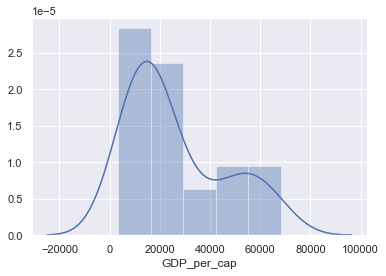

In [10]:
sns.distplot(gdp_per_cap['GDP_per_cap'])

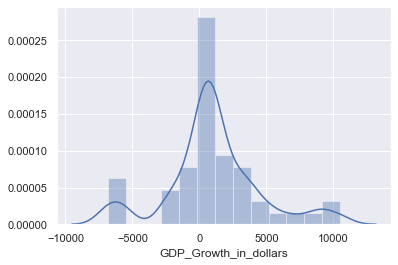

In [11]:
sns.distplot(gdp_per_cap['GDP_Growth_in_dollars'])

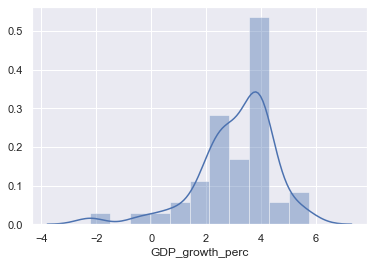

In [12]:
sns.distplot(gdp_growth['GDP_growth_perc'])

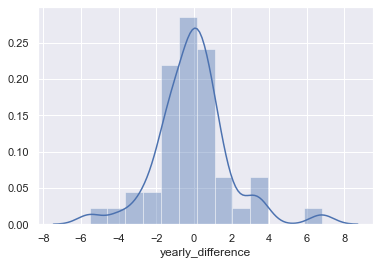

In [13]:
sns.distplot(gdp_growth['yearly_difference'])

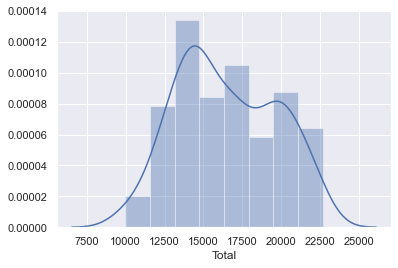

In [14]:
sns.distplot(house_commitment['Total'])

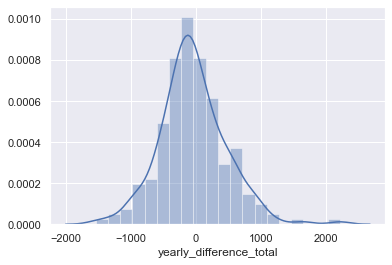

In [15]:
sns.distplot(house_commitment['yearly_difference_total'])

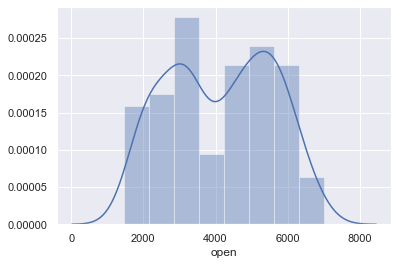

In [16]:
sns.distplot(asx200_month['open'])

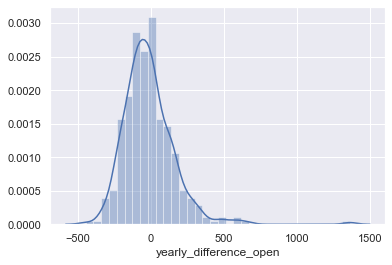

In [17]:
sns.distplot(asx200_month['yearly_difference_open'])

### Visualisations

#### ASX 200 Index vs Housing Commitments

In [18]:
# Filter `asx200 ` with the same date in `new loan commitment` (2002-07-01 ~ 2020-07-01)
start_date_a = "2002-07-01"
end_date_a = "2020-07-01"

after_start_date_a = asx200_month["date"] >= start_date_a
before_end_date_a = asx200_month["date"] <= end_date_a
between_two_dates_a = after_start_date_a & before_end_date_a
asx200_month_a = asx200_month.loc[between_two_dates_a]
asx200_month_a.head()
asx200_month_a.tail()

date         open         high          low        close  \
327 2020-03-01  6438.899902  6524.299805  4402.500000  5076.799805   
328 2020-04-01  5076.799805  5563.600098  5022.399902  5522.399902   
329 2020-05-01  5522.399902  5922.000000  5169.600098  5755.700195   
330 2020-06-01  5755.700195  6198.600098  5705.399902  5897.899902   
331 2020-07-01  5897.899902  6160.600098  5892.799805  5927.799805   

       adj_close      volume  yearly_difference_open  
327  5076.799805  32576400.0              578.300293  
328  5522.399902  19759100.0             1362.100098  
329  5755.700195  19852500.0             -445.600098  
330  5897.899902  22199500.0             -233.300293  
331  5927.799805  14681000.0             -142.199707

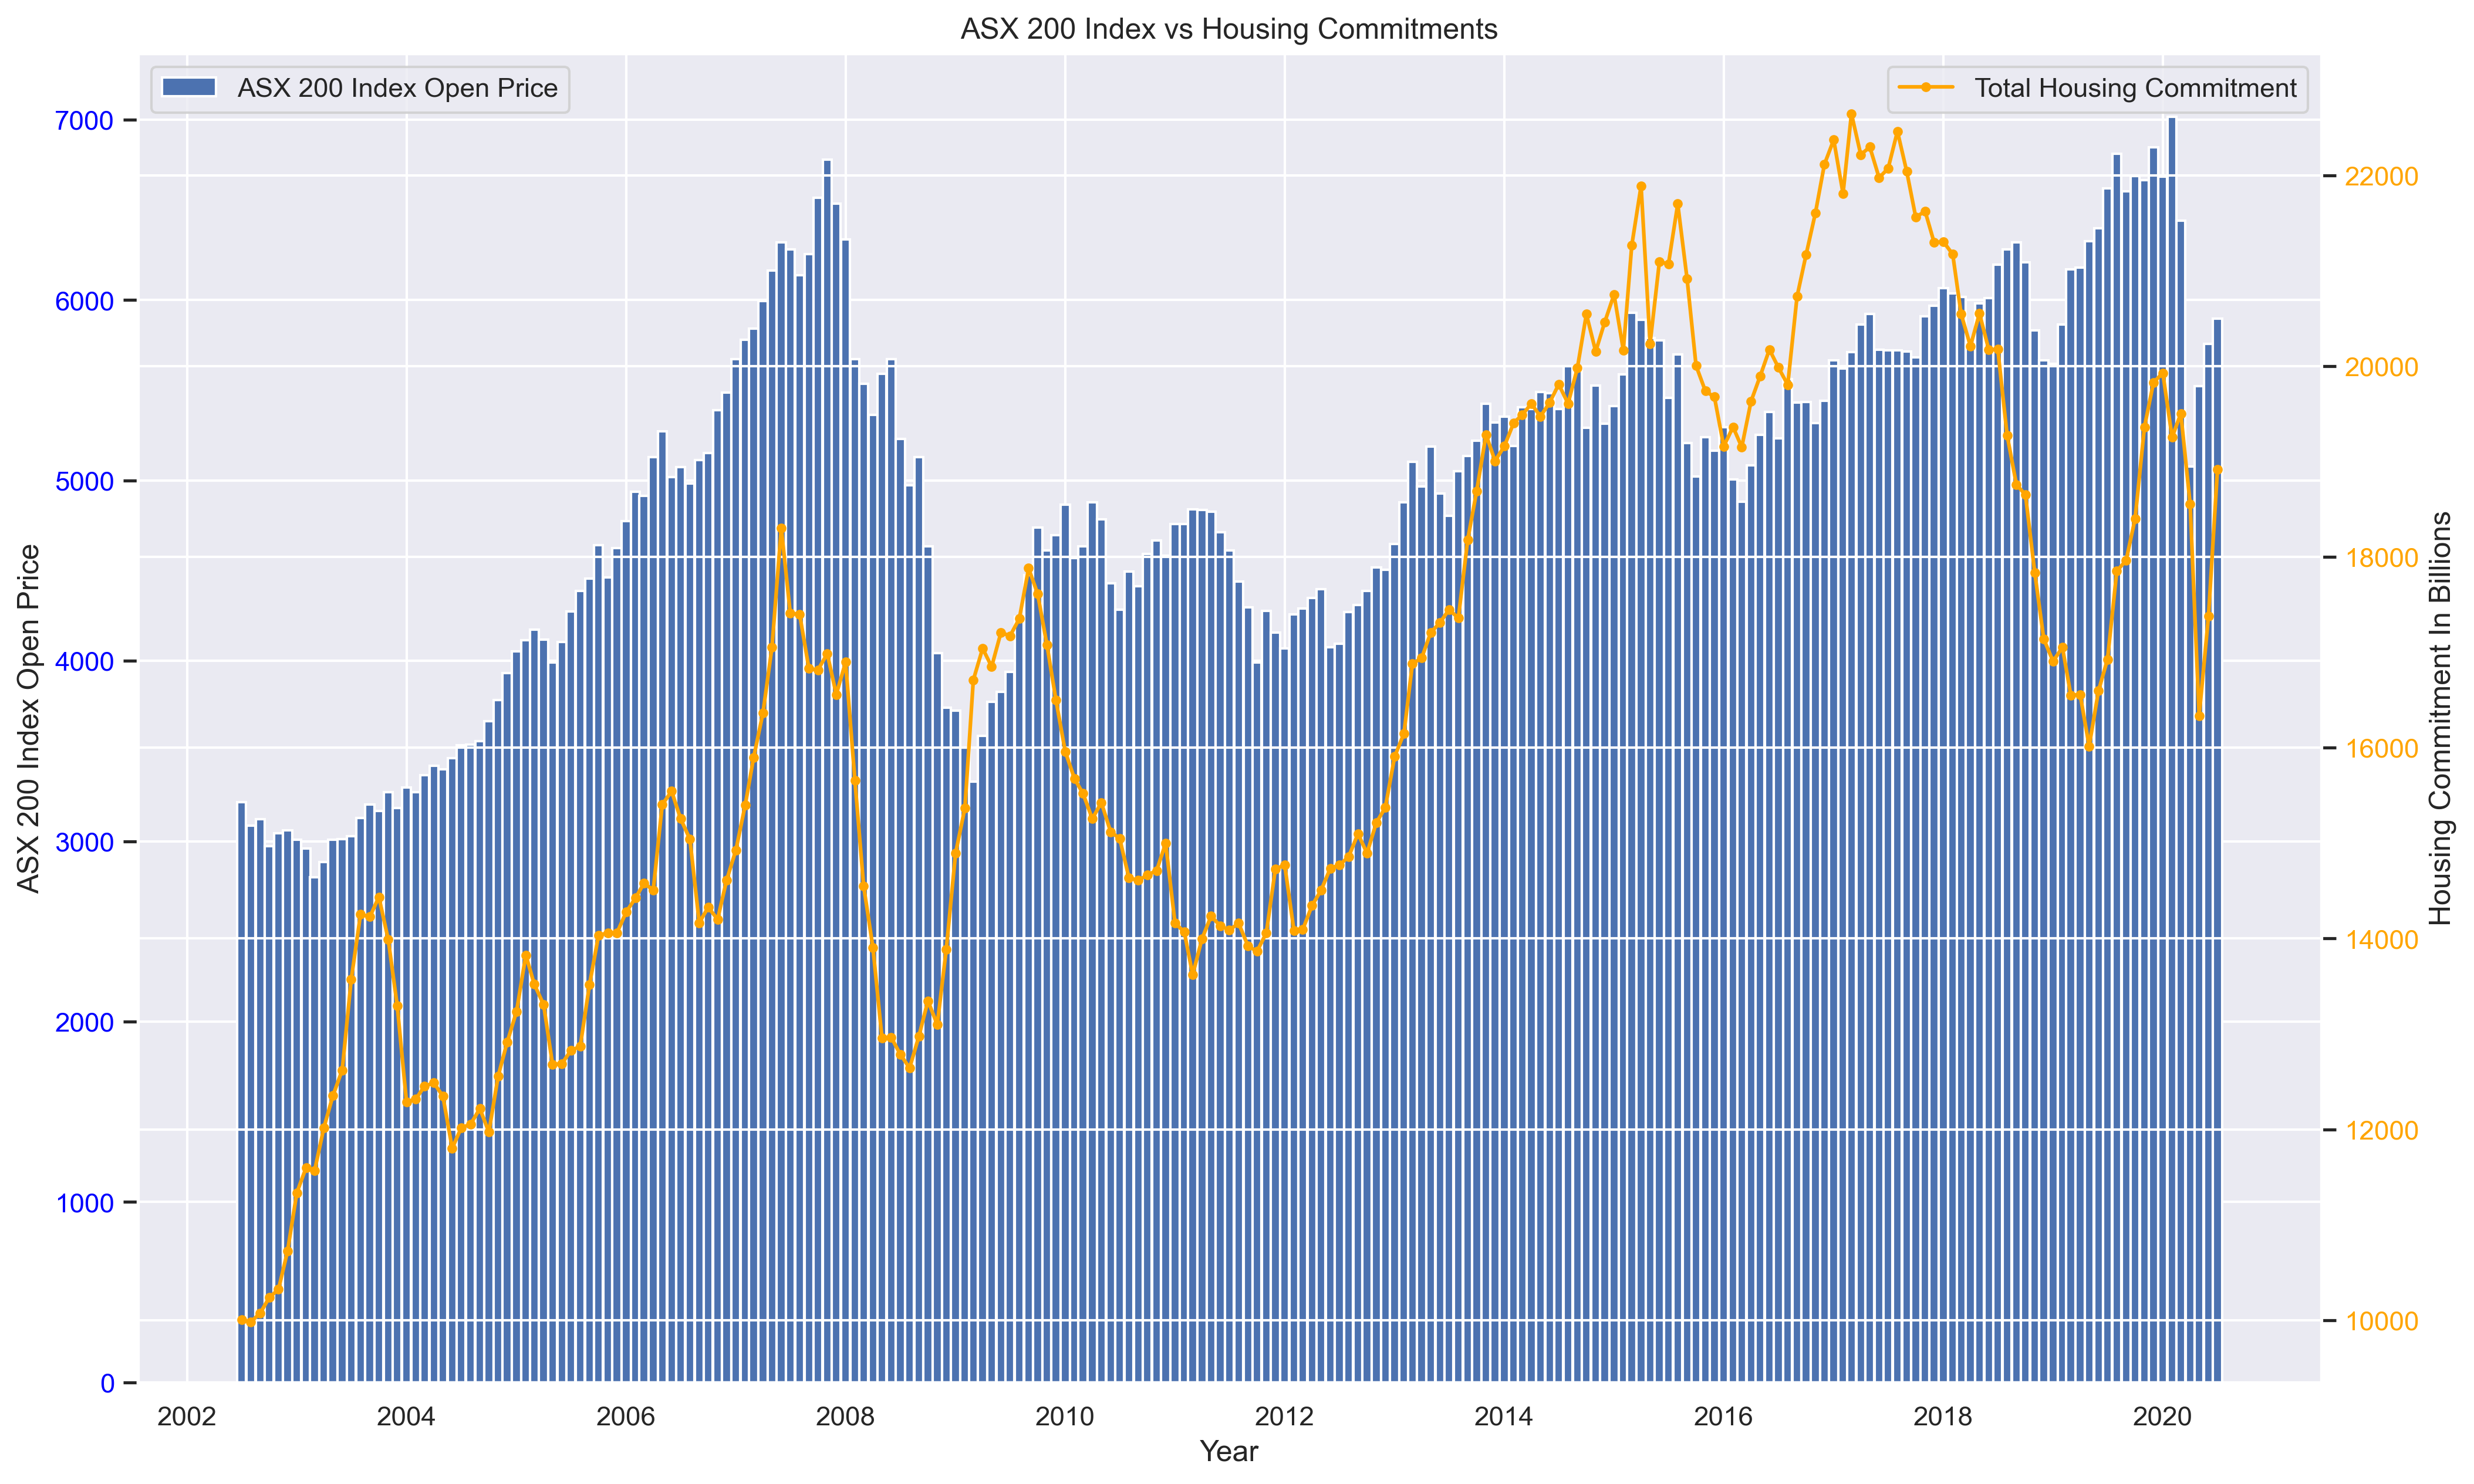

In [19]:
# Create the line charts for ASX 200 Index vs Housing Commitments
total = house_commitment['Total'].tolist()
total_diff = house_commitment['yearly_difference_total'].tolist()
asx200_open_a = asx200_month_a['open'].tolist()
asx200_diff_a = asx200_month_a['yearly_difference_open'].tolist()
month_a = asx200_month_a['date'].tolist()

fig = plt.figure(figsize = (16,10), dpi = 300)

axes1 = fig.add_subplot(111)
axes1.set_xlabel('Year')
axes1.set_ylabel('ASX 200 Index Open Price')
lns1 = axes1.bar(month_a, asx200_open_a, width=30, align = 'center', label = 'ASX 200 Index Open Price')
axes1.tick_params(axis='y', labelcolor="blue")
axes1.legend(loc = "upper left")

axes2 = axes1.twinx()

color = 'tab:blue'
axes2.set_ylabel('Housing Commitment In Billions')
lns2 = axes2.plot(month_a, total, marker = ".", color = "orange", label = "Total Housing Commitment")
axes2.tick_params(axis='y', labelcolor="orange")
axes2.legend(loc = "upper right")

plt.title('ASX 200 Index vs Housing Commitments')
plt.show()

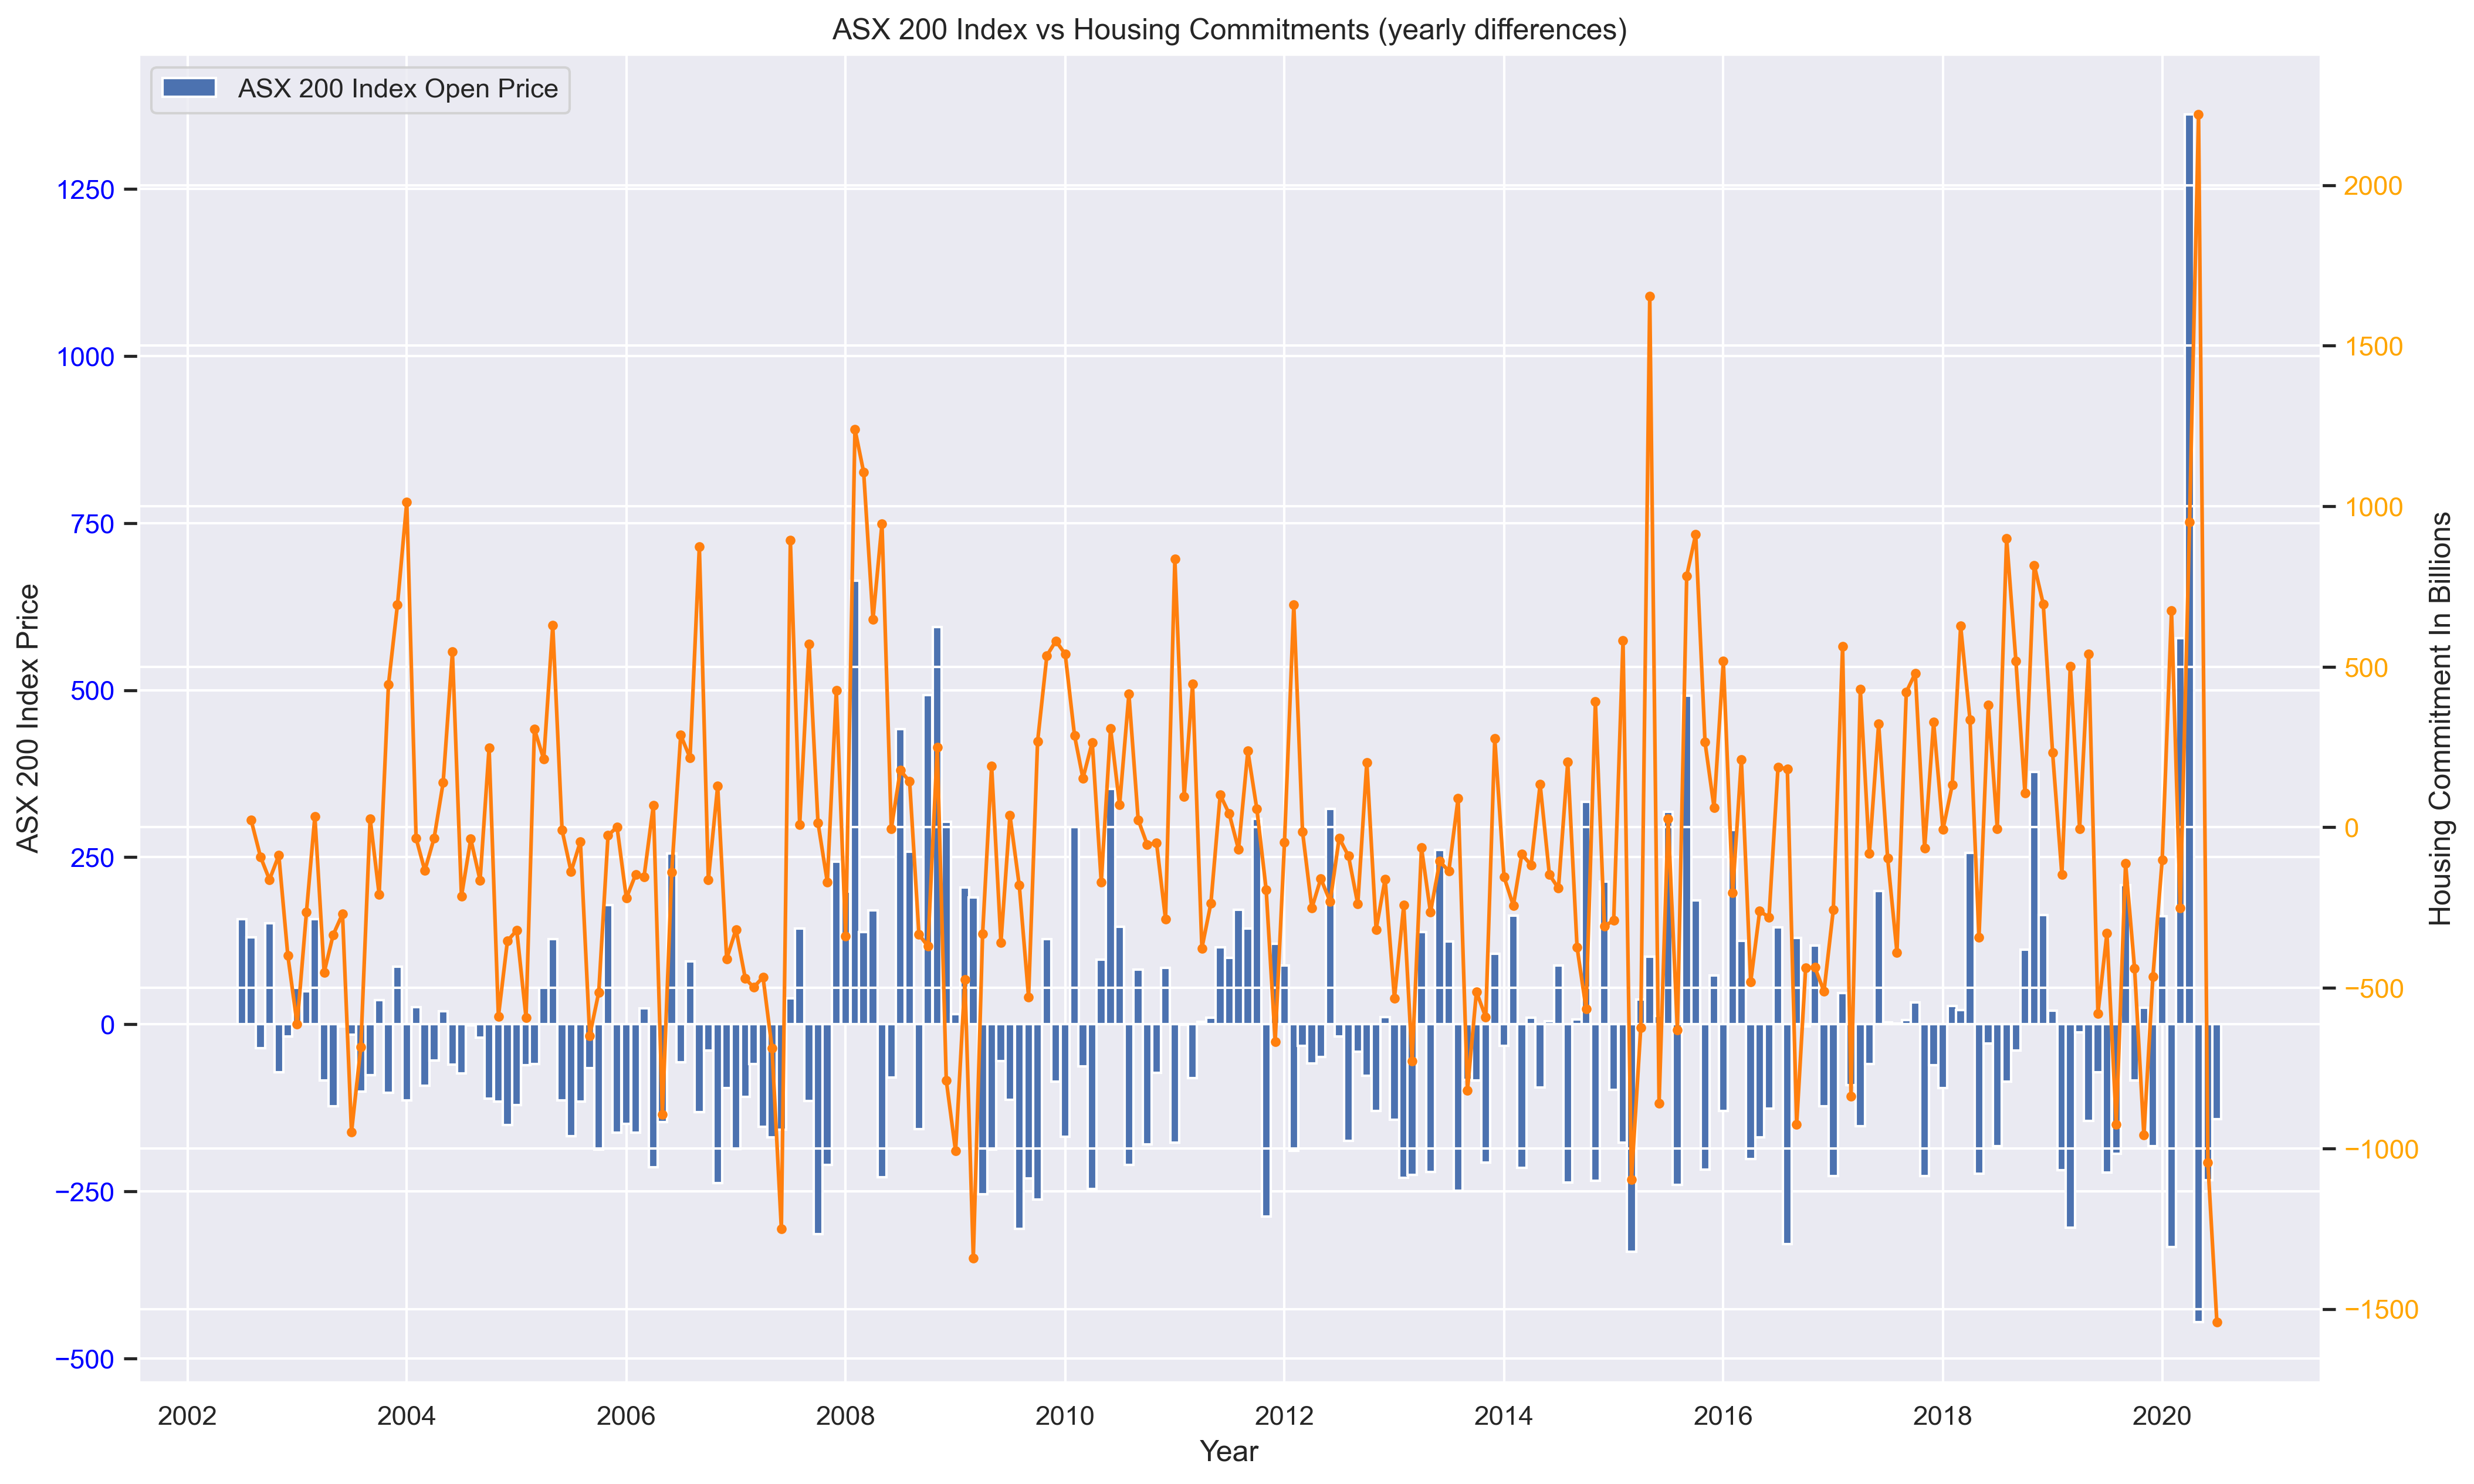

In [20]:
# Maybe this should be removed
# Create the line charts for ASX 200 Index vs Housing Commitments (yearly differences)
total = house_commitment['Total'].tolist()
total_diff = house_commitment['yearly_difference_total'].tolist()
asx200_open_a = asx200_month_a['open'].tolist()
asx200_diff_a = asx200_month_a['yearly_difference_open'].tolist()
month_a = asx200_month_a['date'].tolist()

fig = plt.figure(figsize = (16,10), dpi = 300)

axes1 = fig.add_subplot(111)
axes1.set_xlabel('Year')
axes1.set_ylabel('ASX 200 Index Price')
lns1 = axes1.bar(month_a, asx200_diff_a, width=30, align = 'center', label = 'ASX 200 Index Open Price')
axes1.tick_params(axis='y', labelcolor="blue")
axes1.legend(loc = "upper right")

axes2 = axes1.twinx()

color = 'tab:orange'
axes2.set_ylabel('Housing Commitment In Billions')
lns2 = axes2.plot(month_a, total_diff, marker = ".", color = color, label = "Total Housing Commitment")
axes2.tick_params(axis='y', labelcolor="orange")
axes1.legend(loc = "upper left")

plt.title('ASX 200 Index vs Housing Commitments (yearly differences)')
plt.show()

#### ASX 200 Index vs Per Capita GDP

In [21]:
# Filter `asx200` and `gdp_per_cap` with the common time period (1992-12-01 ~ 2020-01-01)

## `asx200` (1992-12-01 ~ 2020-01-01)
start_date_b = "1993-01-01"
end_date_b = "2020-01-01"

after_start_date_b = asx200_month["date"] >= start_date_b
before_end_date_b = asx200_month["date"] <= end_date_b
between_two_dates_b = after_start_date_b & before_end_date_b
asx200_month_b = asx200_month.loc[between_two_dates_b]
asx200_month_b.head()
asx200_month_b.tail()


date         open         high          low        close  \
321 2019-09-01  6604.200195  6775.600098  6503.899902  6688.299805   
322 2019-10-01  6688.600098  6766.200195  6489.899902  6663.399902   
323 2019-11-01  6663.399902  6893.700195  6634.700195  6846.000000   
324 2019-12-01  6846.000000  6890.000000  6590.100098  6684.100098   
325 2020-01-01  6684.100098  7144.899902  6669.200195  7017.200195   

       adj_close      volume  yearly_difference_open  
321  6688.299805  14700500.0              208.399902  
322  6663.399902  12288700.0              -84.399902  
323  6846.000000  12654500.0               25.200195  
324  6684.100098  11123500.0             -182.600098  
325  7017.200195  11002700.0              161.899902

In [22]:
## `gdp_per_cap` (1992-12-01 ~ 2019-01-01)
start_date_c = "1992-12-01"
end_date_c = "2019-01-01"

after_start_date_c = gdp_per_cap["Year"] >= start_date_c
before_end_date_c = gdp_per_cap["Year"] <= end_date_c
between_two_dates_c = after_start_date_c & before_end_date_c
gdp_per_cap_c = gdp_per_cap.loc[between_two_dates_c]
gdp_per_cap_c.head()
gdp_per_cap_c.tail()

Year  GDP_per_cap  GDP_Growth_in_dollars
44 2015-01-01     56755.72               -5755.07
45 2016-01-01     49971.13               -6784.59
46 2017-01-01     54066.47                4095.34
47 2018-01-01     57395.92                3329.45
48 2019-01-01     54907.10               -2488.82

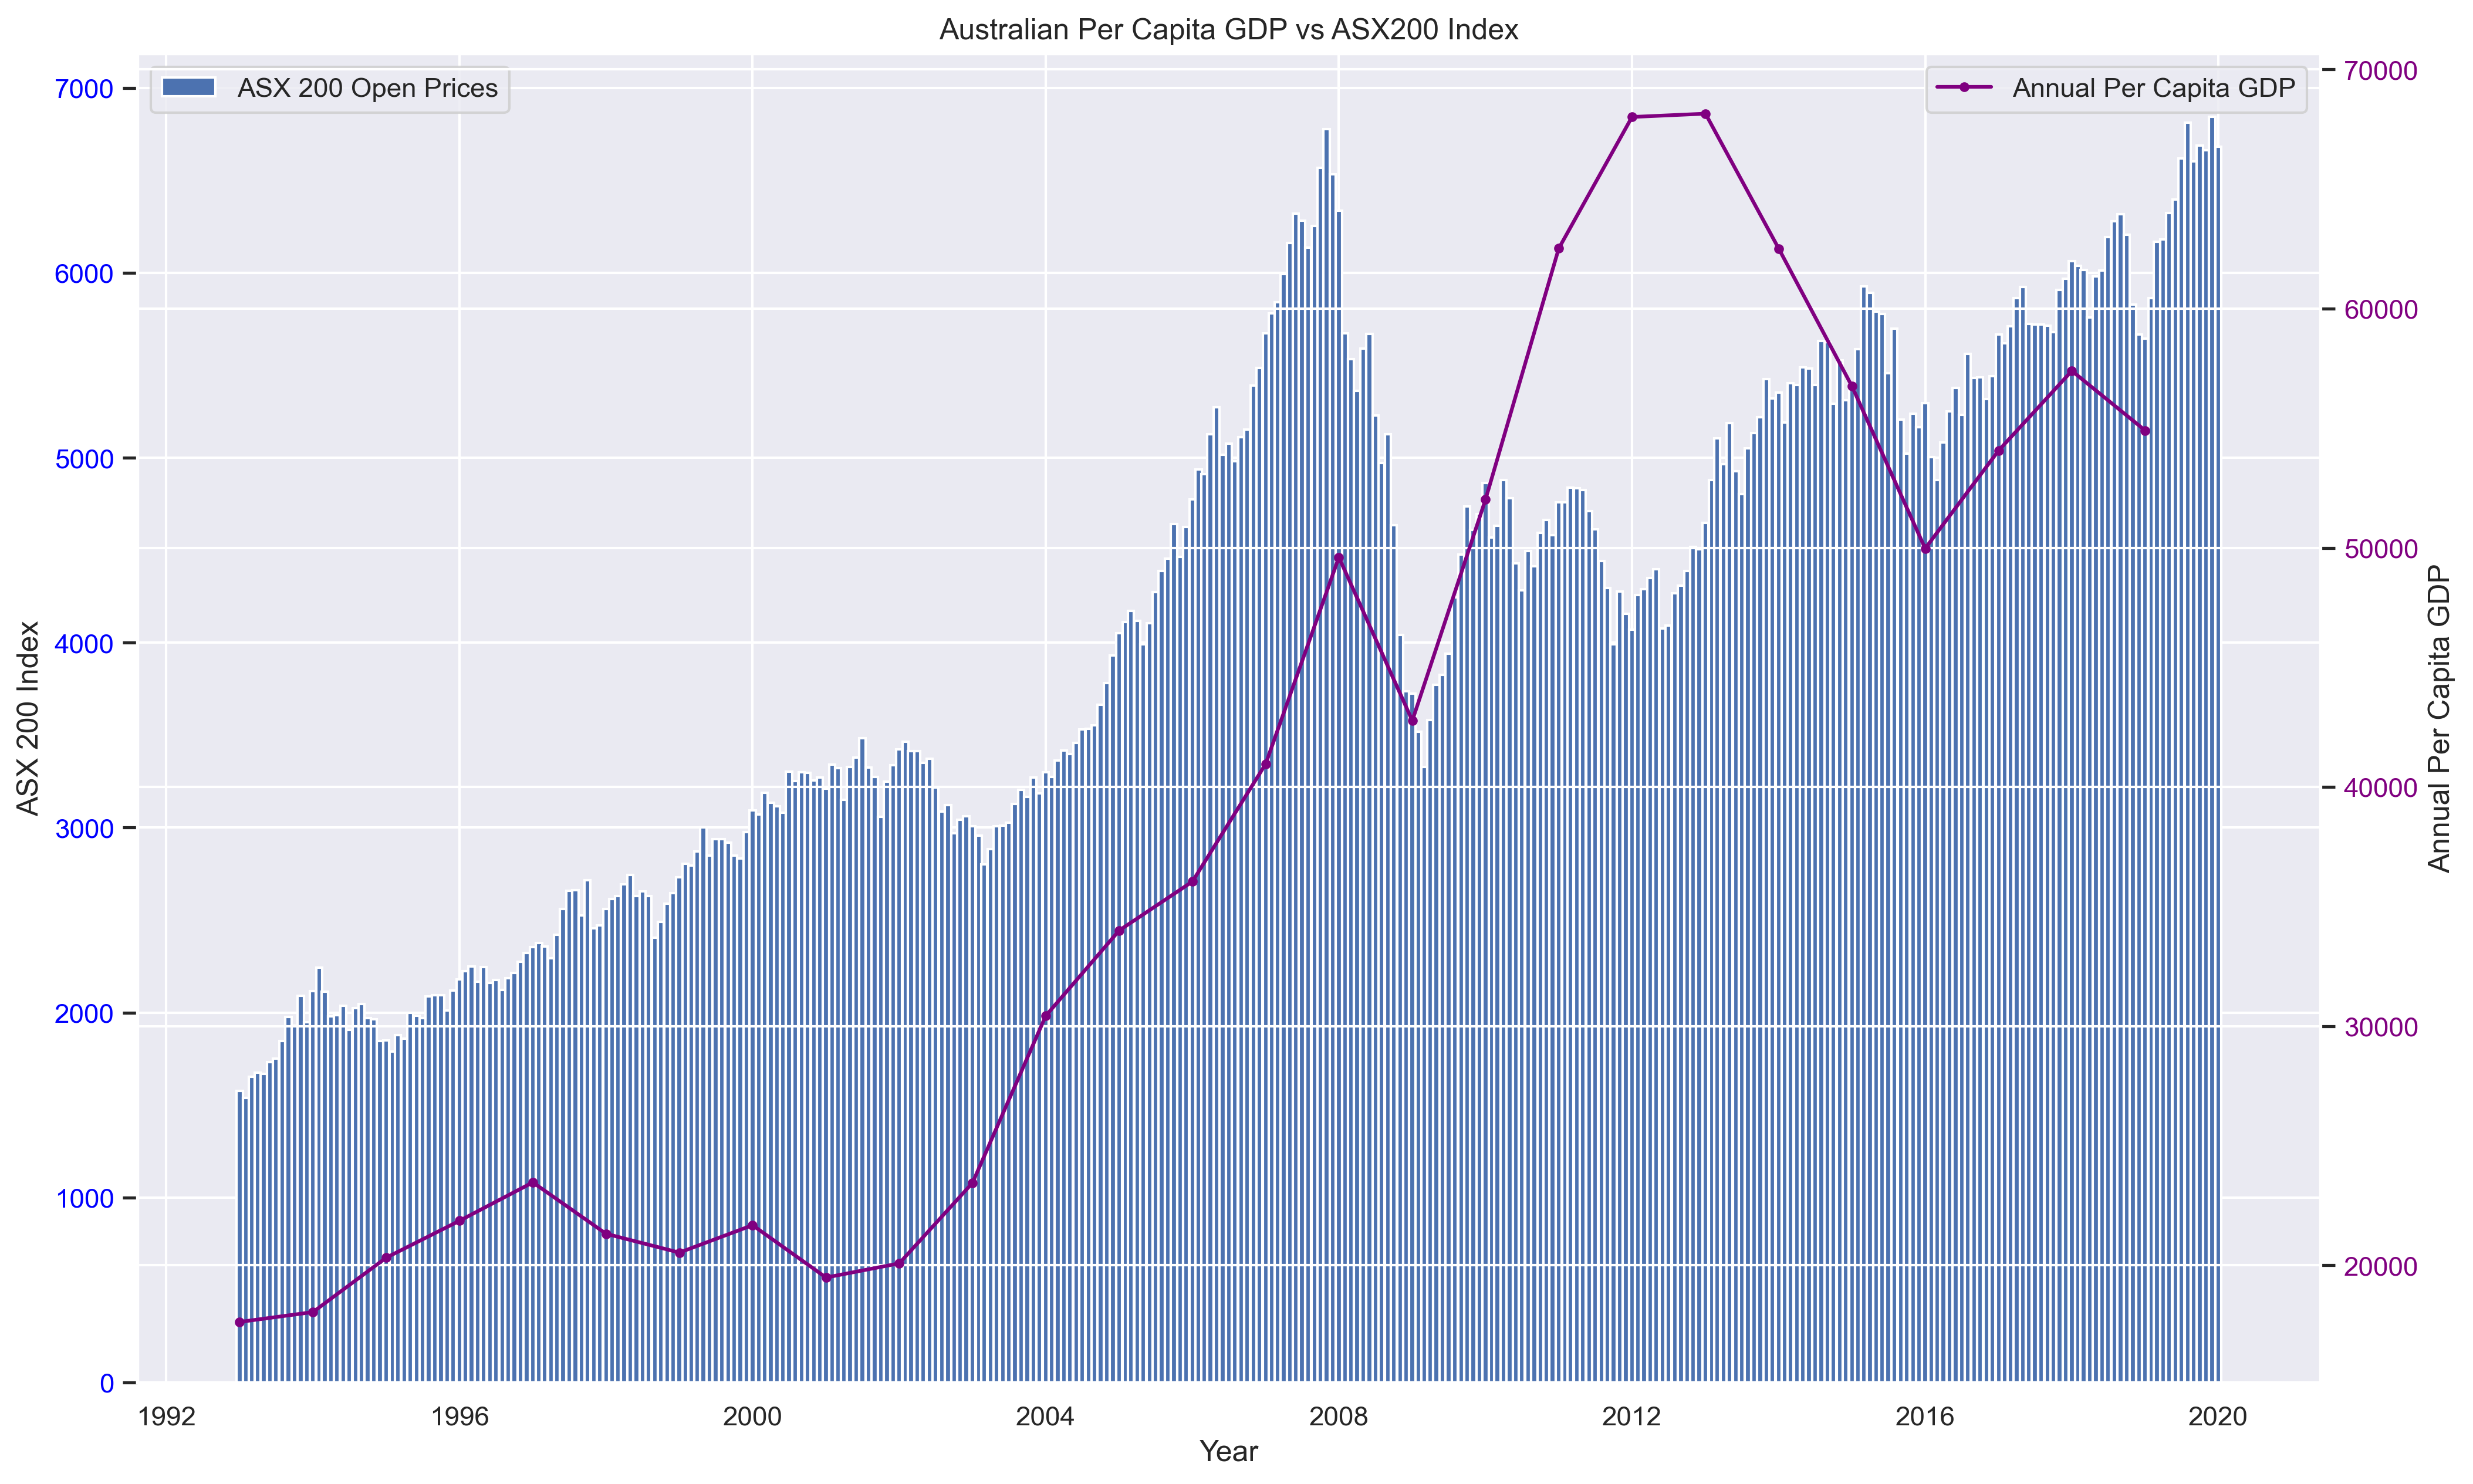

In [23]:
# Create the line charts for ASX 200 Index vs Annual Per Capita GDP 
asx200_open_b = asx200_month_b['open'].tolist()
asx200_diff_b = asx200_month_b['yearly_difference_open'].tolist()
gdp_c = gdp_per_cap_c['GDP_per_cap'].tolist()
year_c = gdp_per_cap_c['Year'].tolist()
month_b = asx200_month_b['date'].tolist()

fig = plt.figure(figsize = (16,10), dpi = 300)

axes1 = fig.add_subplot(111)
axes1.set_xlabel('Year')
axes1.set_ylabel('ASX 200 Index')
lns1 = axes1.bar(month_b, asx200_open_b, width=30, align = 'center', label = 'ASX 200 Open Prices')
axes1.legend(loc = "upper left")

axes2 = axes1.twinx()

color = 'tab:purple'
axes2.set_ylabel('Annual Per Capita GDP')
lns2 = axes2.plot(year_c, gdp_c, marker = ".", color = "purple", label = "Annual Per Capita GDP")
axes1.tick_params(axis='y', labelcolor="blue")
axes2.tick_params(axis='y', labelcolor="purple")
axes2.legend(loc = "upper right")

plt.title('Australian Per Capita GDP vs ASX200 Index')

plt.show()

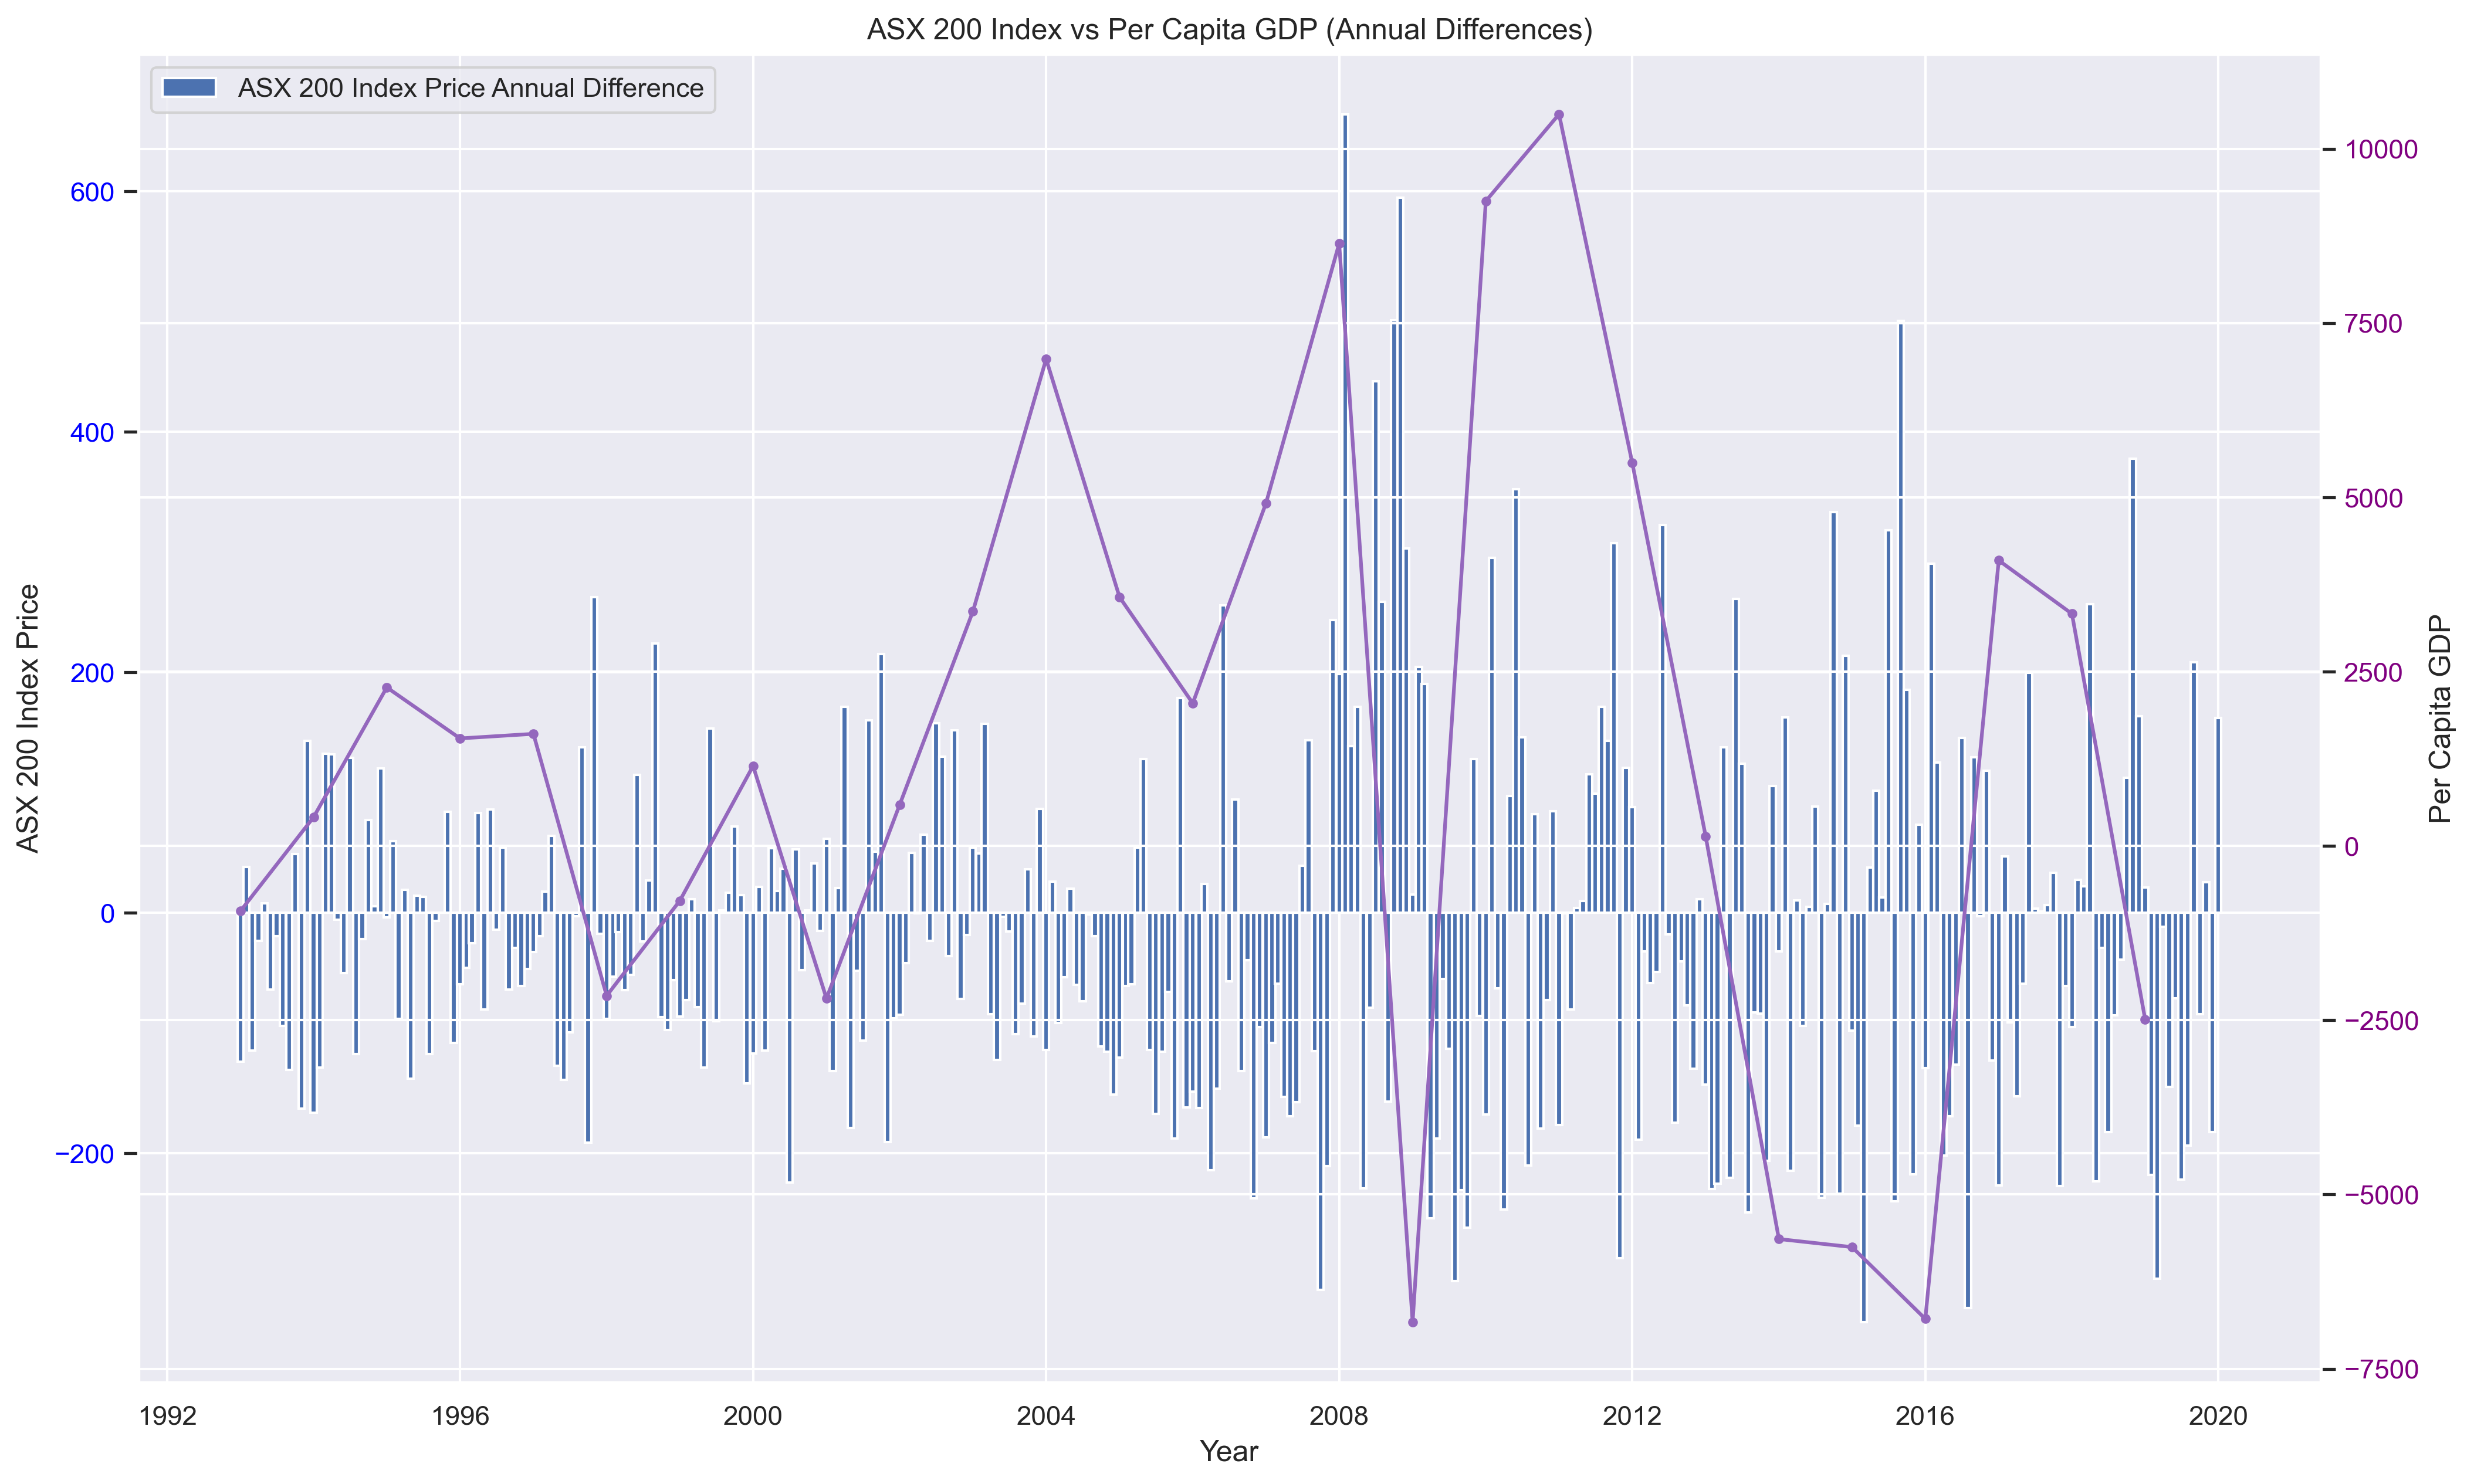

In [24]:
# Maybe this should be removed
# Create charts for ASX 200 Index vs Annual Per Capita GDP  (yearly differences)
asx200_open_b = asx200_month_b['open'].tolist()
asx200_diff_b = asx200_month_b['yearly_difference_open'].tolist()
gdp_c = gdp_per_cap_c['GDP_per_cap'].tolist()
gdp_diff_c = gdp_per_cap_c['GDP_Growth_in_dollars'].tolist()
year_c = gdp_per_cap_c['Year'].tolist()
month_b = asx200_month_b['date'].tolist()

fig = plt.figure(figsize = (16,10), dpi = 300)

axes1 = fig.add_subplot(111)
axes1.set_xlabel('Year')
axes1.set_ylabel('ASX 200 Index Price')
lns1 = axes1.bar(month_b, asx200_diff_b, width=30, align = 'center', label = 'ASX 200 Index Price Annual Difference')
axes1.tick_params(axis='y', labelcolor="blue")
axes1.legend(loc = "upper right")

axes2 = axes1.twinx()

color = 'tab:purple'
axes2.set_ylabel('Per Capita GDP')
lns2 = axes2.plot(year_c, gdp_diff_c, marker = ".", color = color, label = "Per Capita GDP Annual Difference")
axes2.tick_params(axis='y', labelcolor="purple")
axes1.legend(loc = "upper left")

plt.title('ASX 200 Index vs Per Capita GDP (Annual Differences)')
plt.show()

#### Per Capita GDP vs Housing Commitments

In [25]:
## filter `gdp_per_cap` again to match `house_commitment` time period (2002-07-01 ~ 2019-01-01)
start_date_d = "2002-07-01"
end_date_d = "2019-01-01"

after_start_date_d = gdp_per_cap["Year"] >= start_date_d
before_end_date_d = gdp_per_cap["Year"] <= end_date_d
between_two_dates_d = after_start_date_d & before_end_date_d
gdp_per_cap_d = gdp_per_cap.loc[between_two_dates_d]
gdp_per_cap_d.head()
gdp_per_cap_d.tail()

Year  GDP_per_cap  GDP_Growth_in_dollars
44 2015-01-01     56755.72               -5755.07
45 2016-01-01     49971.13               -6784.59
46 2017-01-01     54066.47                4095.34
47 2018-01-01     57395.92                3329.45
48 2019-01-01     54907.10               -2488.82

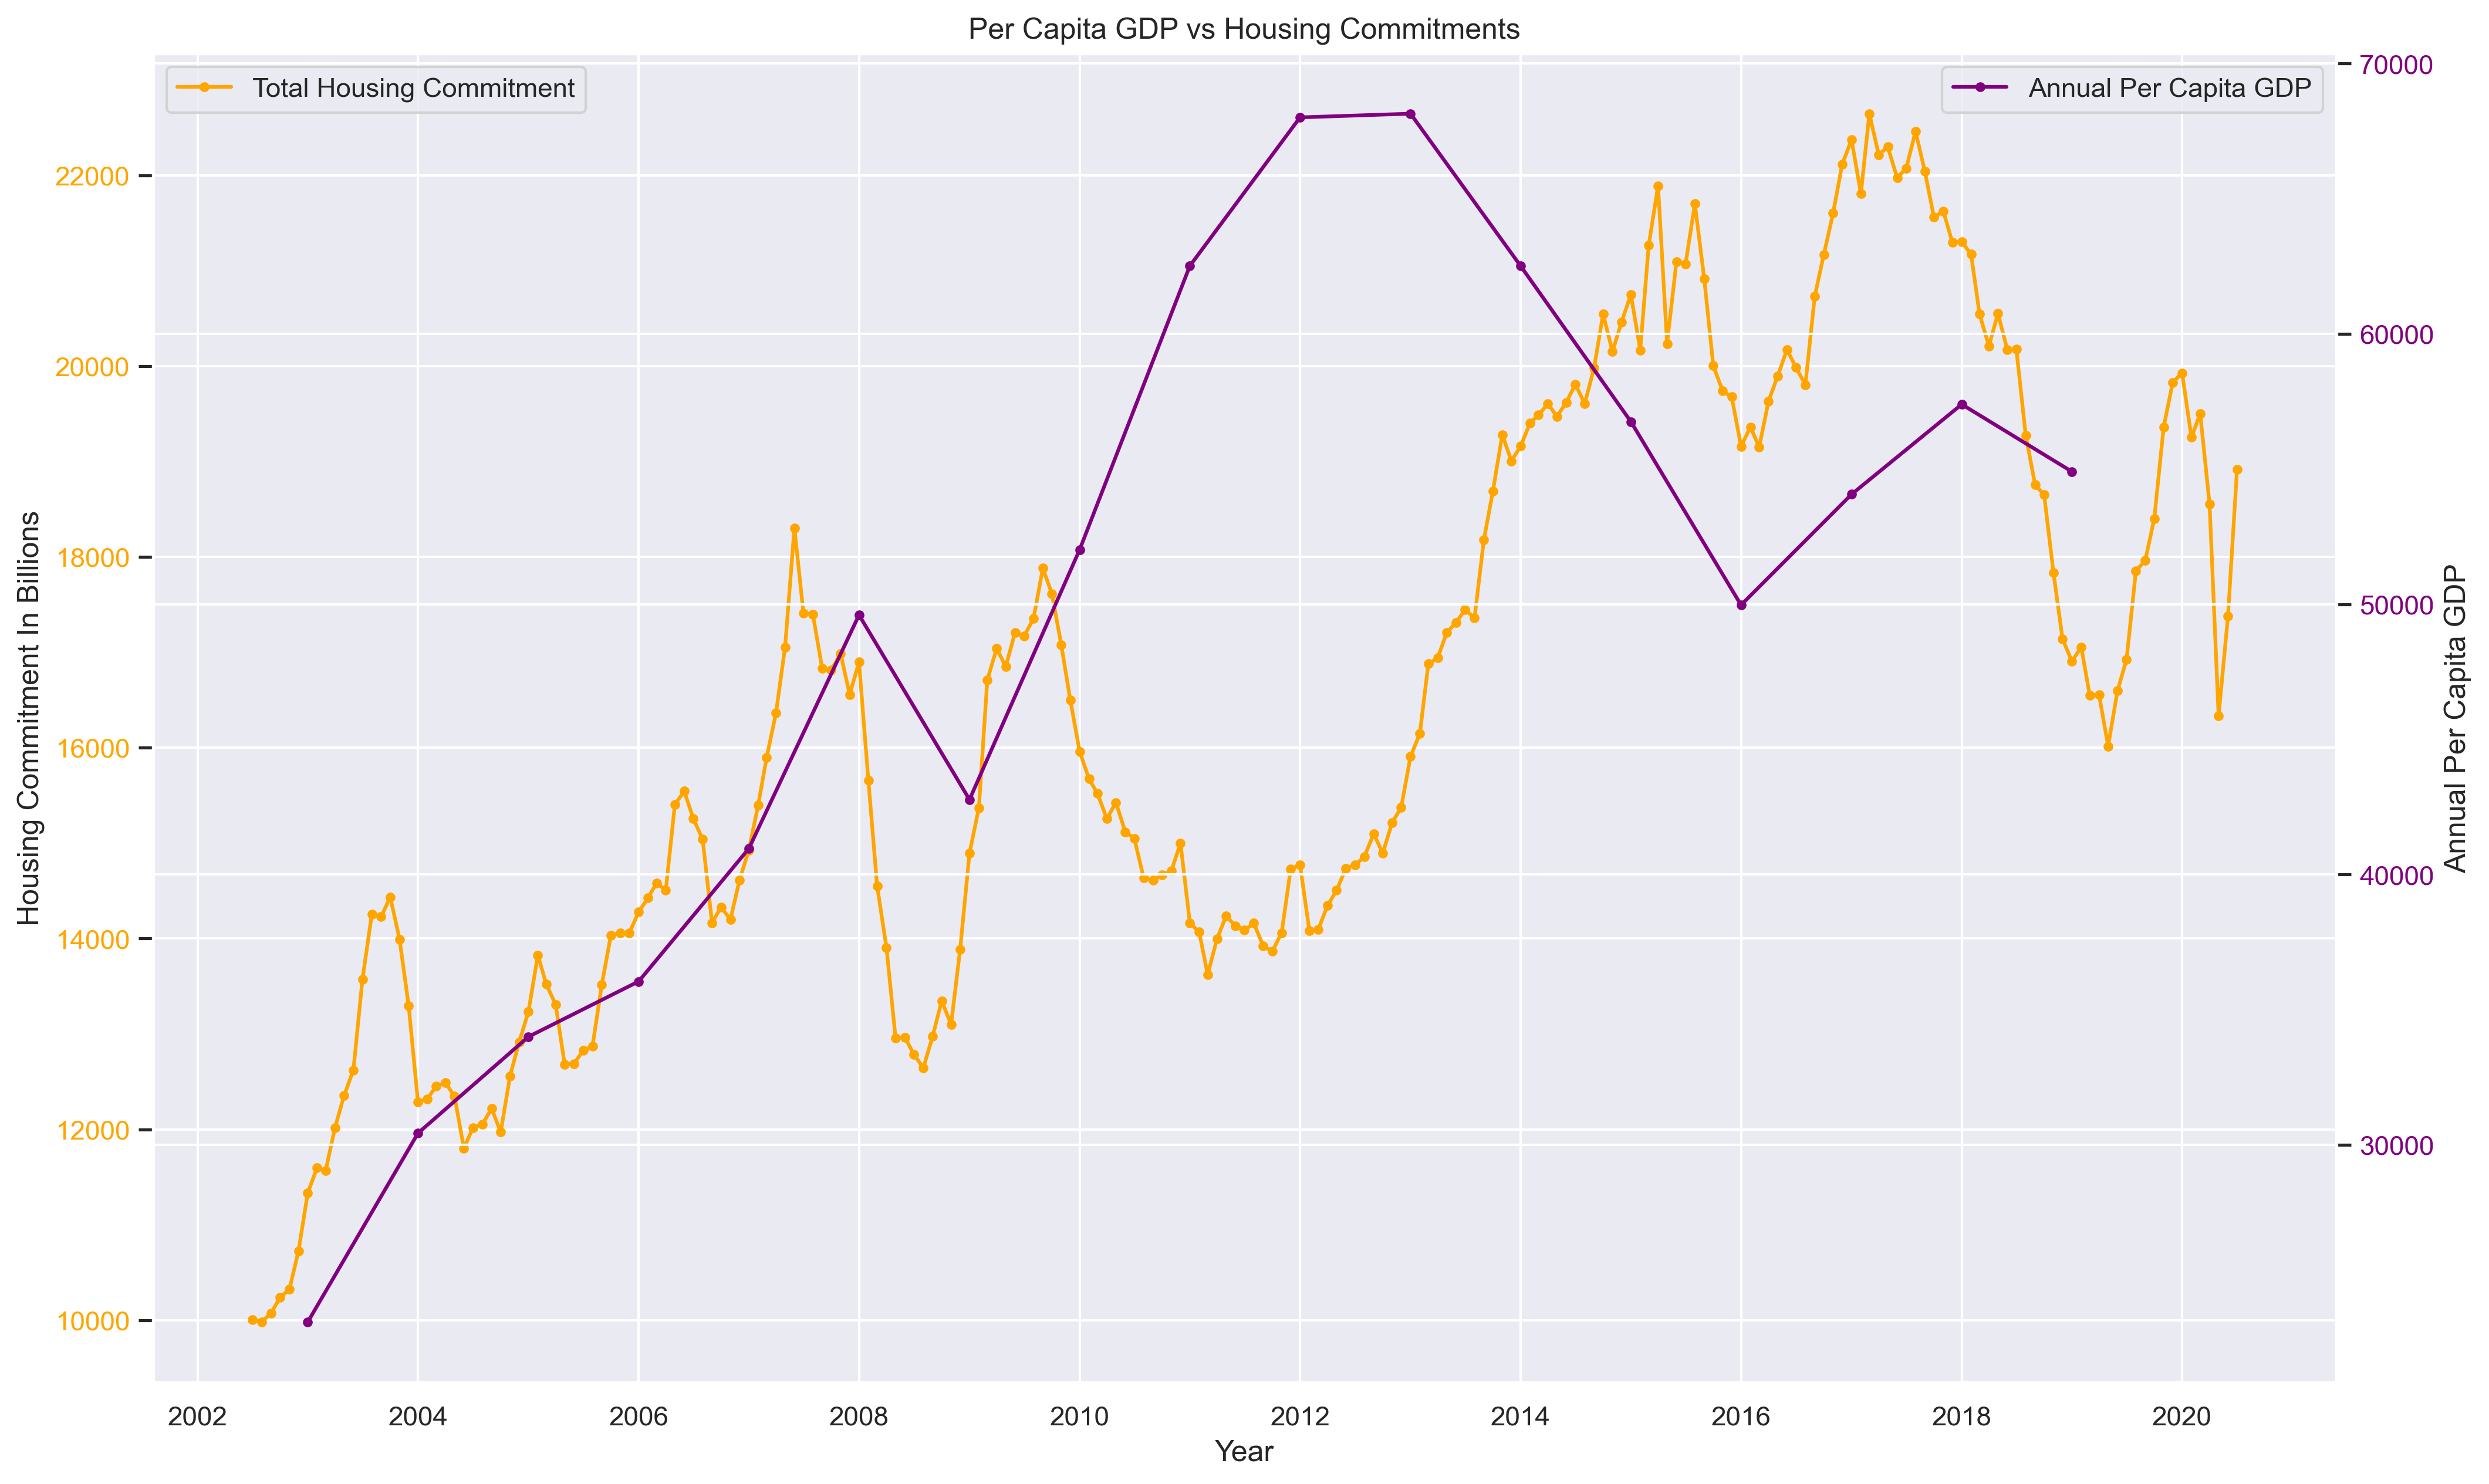

In [26]:
# Create the line charts for Per Capita GDP vs Housing Commitments
total = house_commitment['Total'].tolist()
total_diff = house_commitment['yearly_difference_total'].tolist()
month_c = house_commitment['Date'].tolist()

gdp_d = gdp_per_cap_d['GDP_per_cap'].tolist()
year_d = gdp_per_cap_d['Year'].tolist()

fig = plt.figure(figsize = (16,10), dpi = 300)

axes1 = fig.add_subplot(111)
axes1.set_xlabel('Year')
axes1.set_ylabel('Housing Commitment In Billions')
lns1 = axes1.plot(month_c, total,marker = ".", color = "orange", label = "Total Housing Commitment")
axes1.tick_params(axis='y', labelcolor="orange")
axes1.legend(loc = "upper left")

axes2 = axes1.twinx()

color = 'tab:purple'
axes2.set_ylabel('Annual Per Capita GDP')
lns2 = axes2.plot(year_d, gdp_d, marker = ".", color = "purple", label = "Annual Per Capita GDP")
axes2.tick_params(axis='y', labelcolor="purple")
axes2.legend(loc = "upper right")

plt.title('Per Capita GDP vs Housing Commitments')
plt.show()

### Have a closer look at them separately 

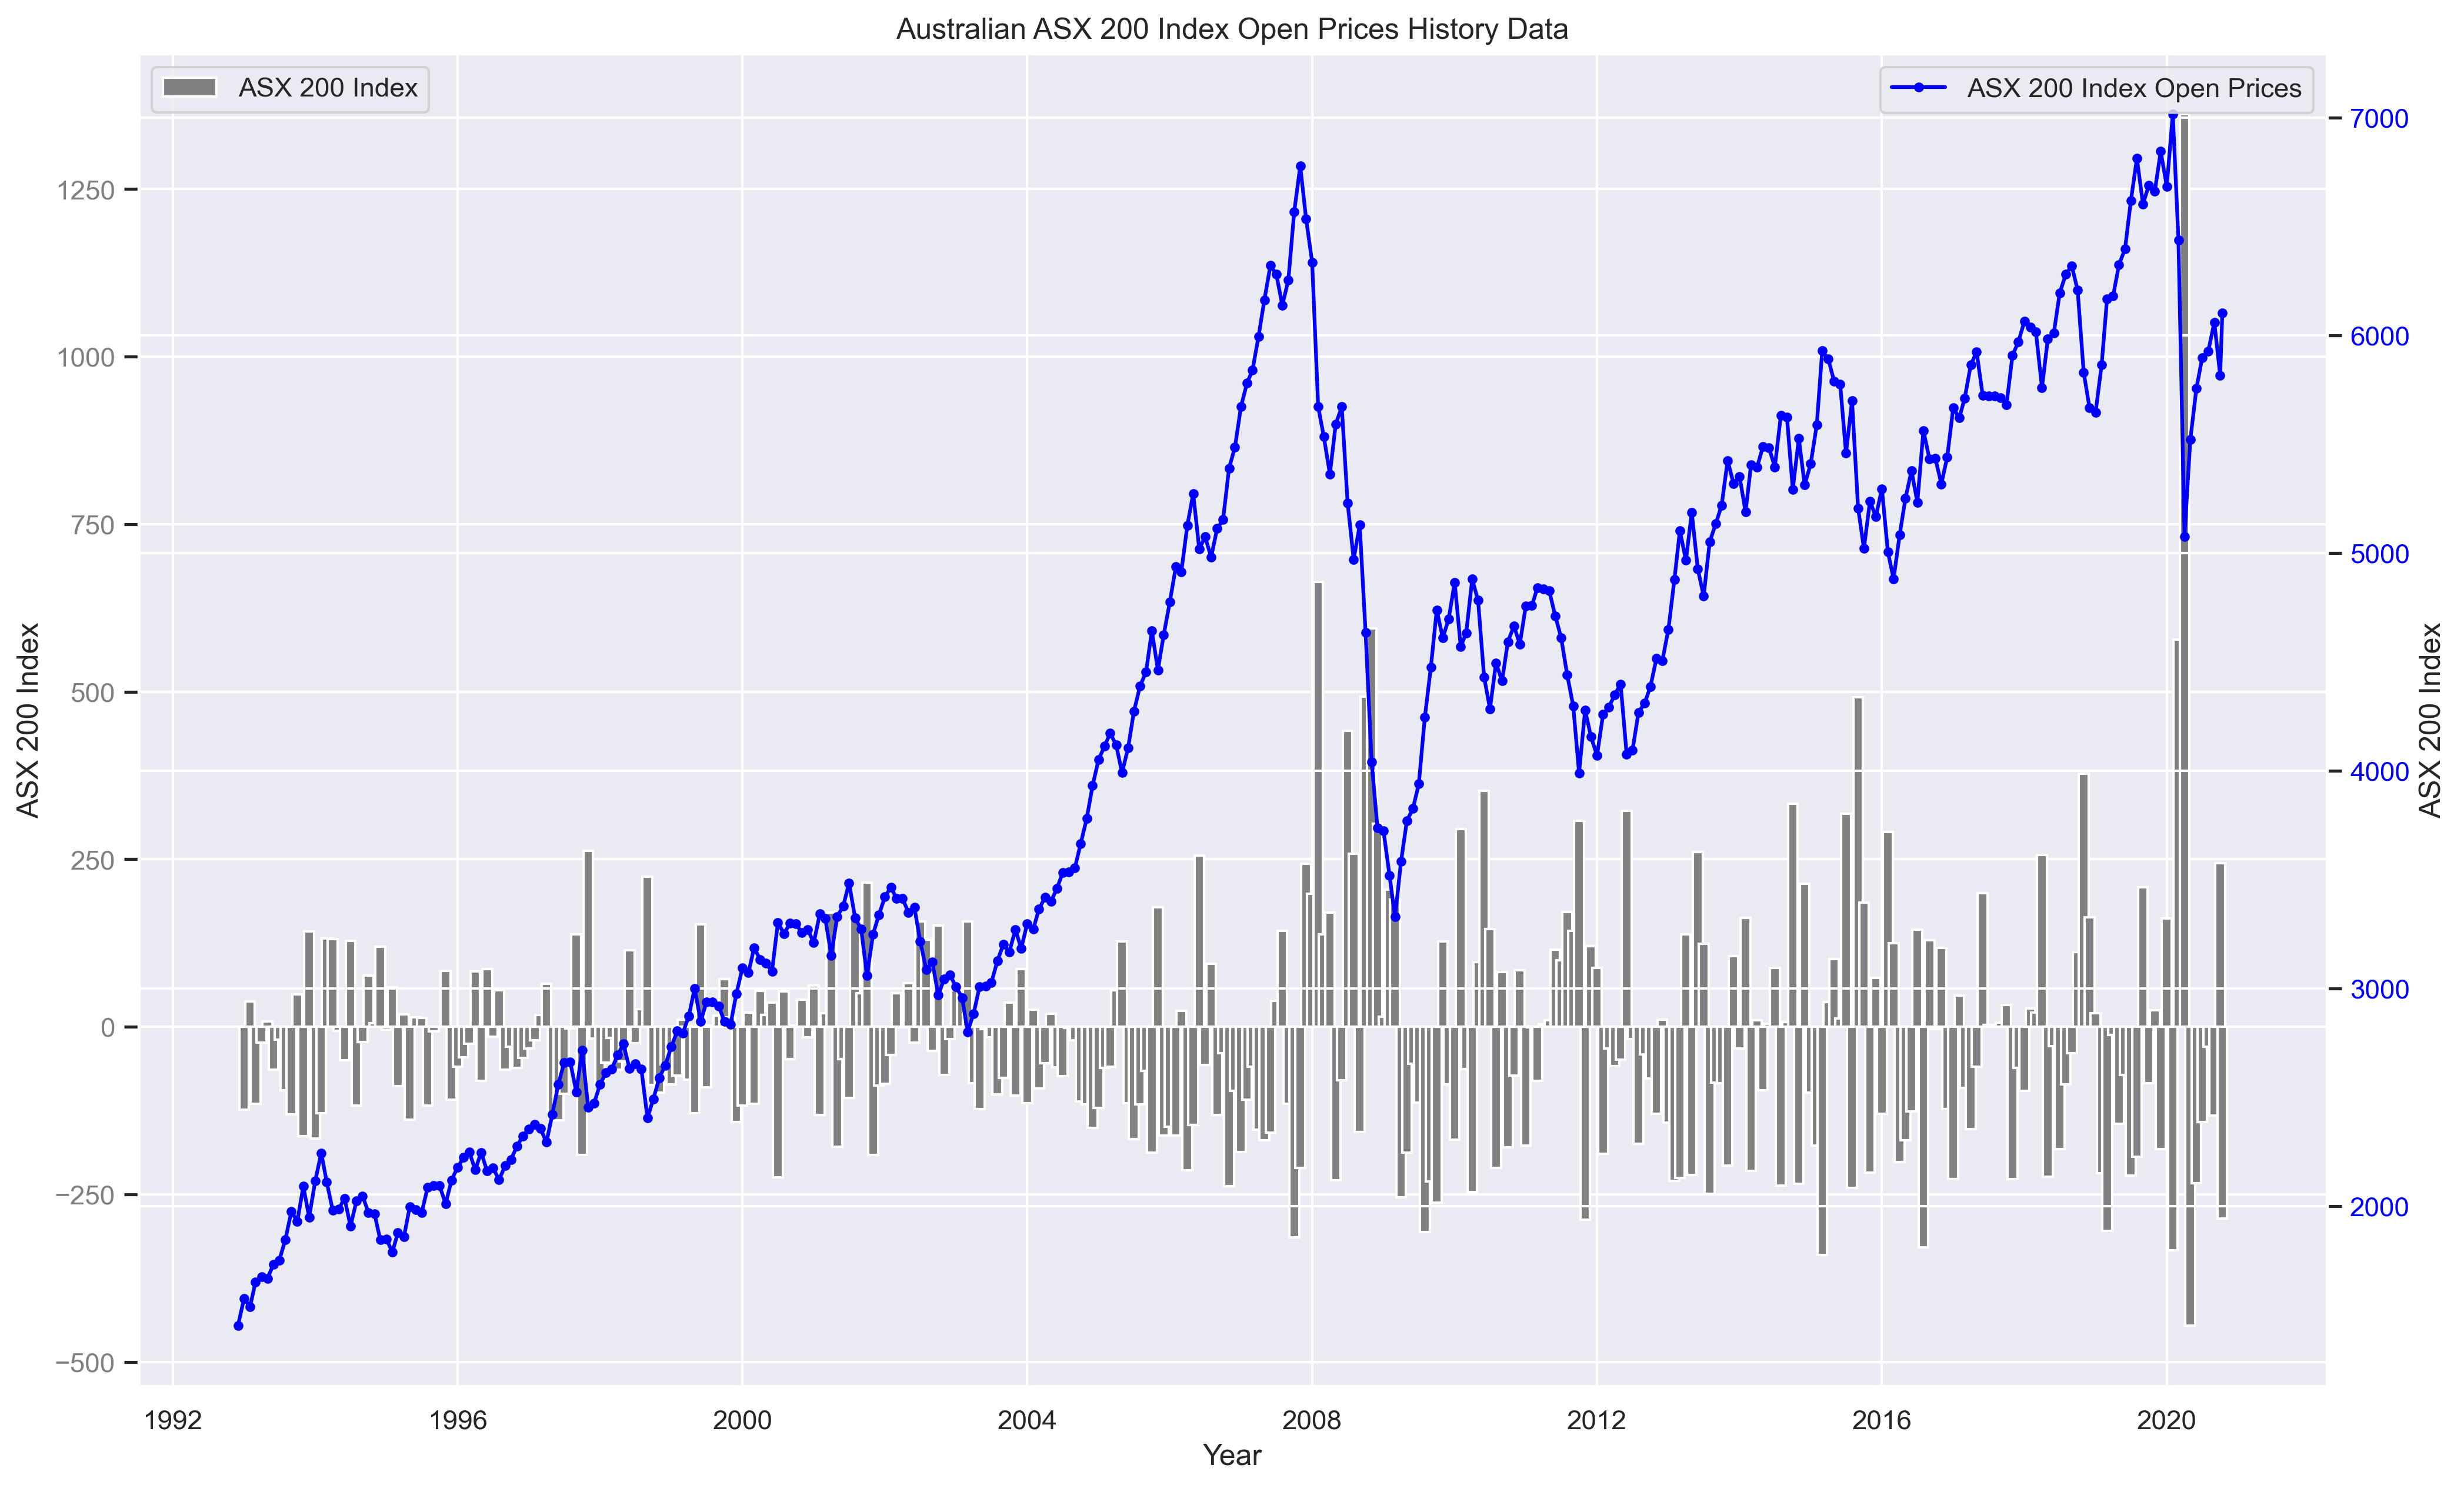

In [27]:
##### Australian AXS 200 Index History Data
new_asx = asx200_month['open'].tolist()
new_asx_diff = asx200_month['yearly_difference_open'].tolist()
new_month = asx200_month['date'].tolist()

fig = plt.figure(figsize = (16,10), dpi = 300)

axes1 = fig.add_subplot(111)
axes1.set_xlabel('Year')
axes1.set_ylabel('ASX 200 Index')
lns1 = axes1.bar(new_month, new_asx_diff, width=50, align = 'center', color = "grey", label = 'ASX 200 Index')
axes1.legend(loc = "upper left")

axes2 = axes1.twinx()

color = 'tab:blue'
axes2.set_ylabel('ASX 200 Index')
lns2 = axes2.plot(new_month, new_asx, marker = ".", color = "blue", label = "ASX 200 Index Open Prices")
axes1.tick_params(axis='y', labelcolor="grey")
axes2.tick_params(axis='y', labelcolor="blue")
axes2.legend(loc = "upper right")

plt.title('Australian ASX 200 Index Open Prices History Data')

plt.show()

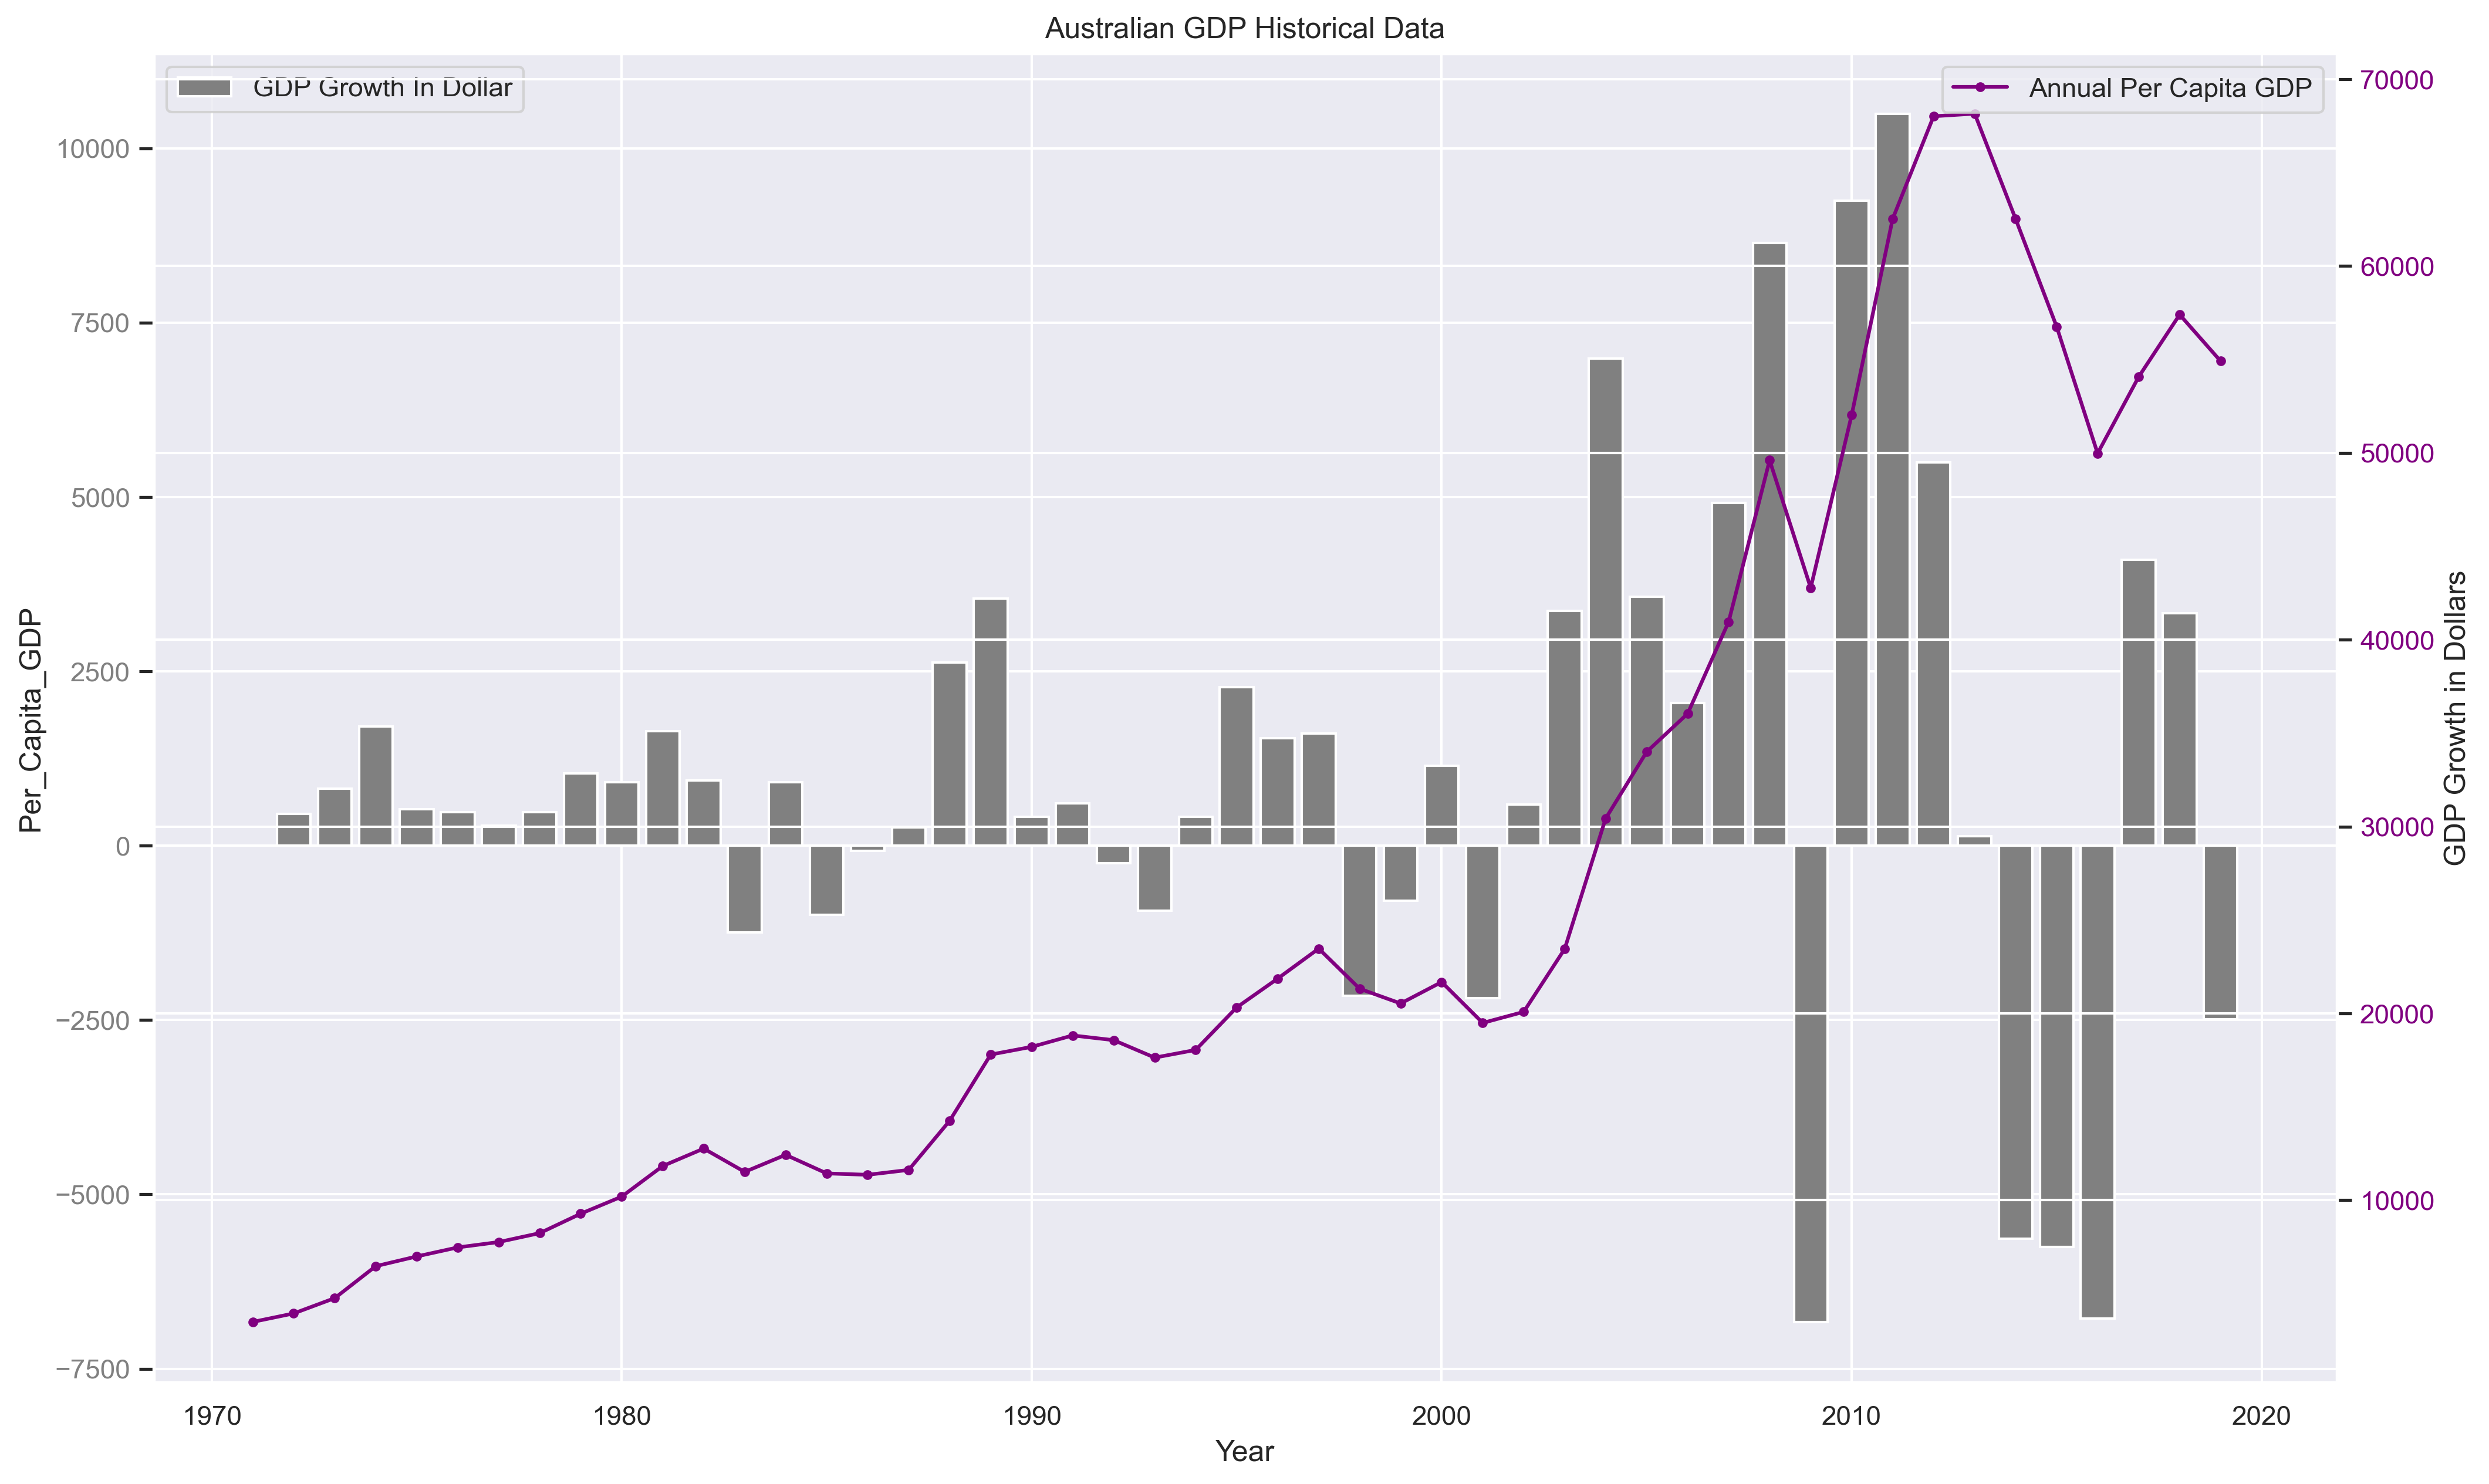

In [28]:
### Australian GDP_per_cap History Data
gdp = gdp_per_cap['GDP_per_cap'].tolist()
diff = gdp_per_cap['GDP_Growth_in_dollars'].tolist()
year = gdp_per_cap['Year'].tolist()

fig = plt.figure(figsize = (16,10), dpi = 300)

axes1 = fig.add_subplot(111)
axes1.set_xlabel('Year')
axes1.set_ylabel('Per_Capita_GDP')
lns1 = axes1.bar(year, diff, width=300, align = 'center', color = "grey", label = 'GDP Growth In Dollar')
axes1.legend(loc = "upper left")

axes2 = axes1.twinx()

color = 'tab:purple'
axes2.set_ylabel('GDP Growth in Dollars')
lns2 = axes2.plot(year, gdp, marker = ".", color = "purple", label = "Annual Per Capita GDP")
axes1.tick_params(axis='y', labelcolor="grey")
axes2.tick_params(axis='y', labelcolor="purple")
axes2.legend(loc = "upper right")

plt.title('Australian GDP Historical Data')

plt.show()

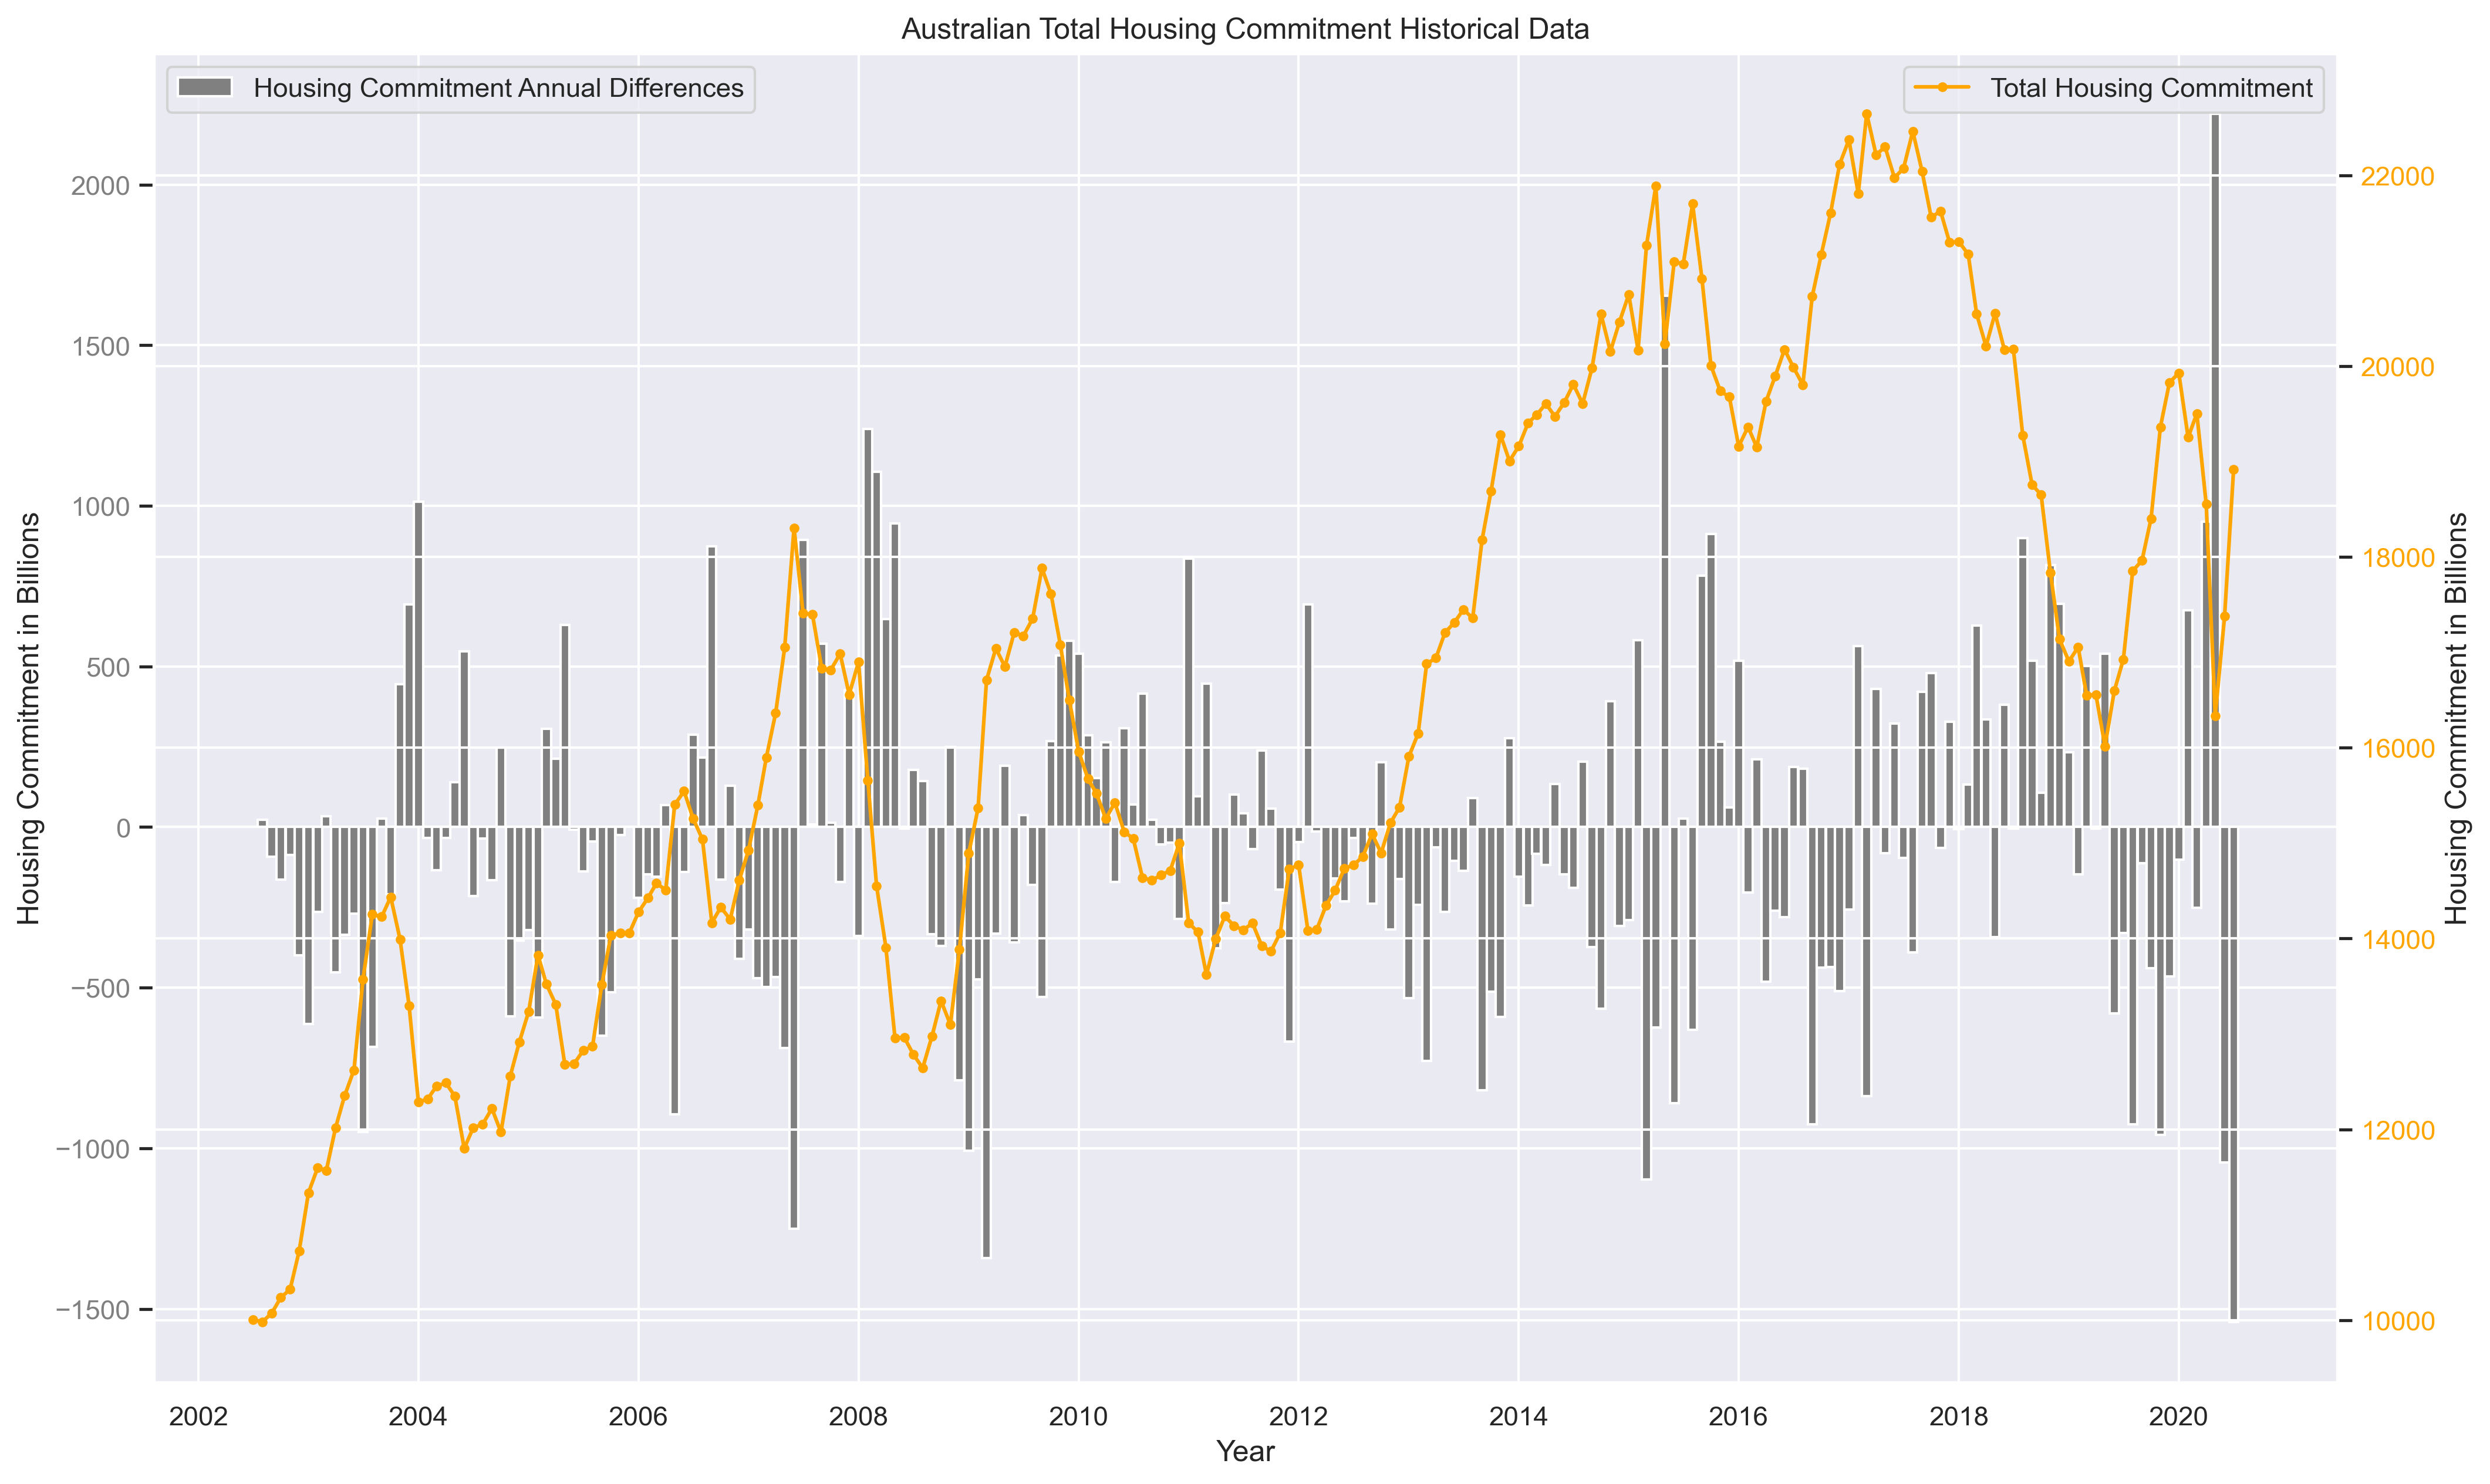

In [29]:
### Australian Housing Commitment History Data
new_total = house_commitment['Total'].tolist()
new_diff = house_commitment['yearly_difference_total'].tolist()
new_date = house_commitment['Date'].tolist()

fig = plt.figure(figsize = (16,10), dpi = 300)

axes1 = fig.add_subplot(111)
axes1.set_xlabel('Year')
axes1.set_ylabel('Housing Commitment in Billions')
lns1 = axes1.bar(new_date, new_diff, width=30, align = 'center', color = "grey", label = 'Housing Commitment Annual Differences')
axes1.legend(loc = "upper left")

axes2 = axes1.twinx()

color = 'tab:orange'
axes2.set_ylabel('Housing Commitment in Billions')
lns2 = axes2.plot(new_date, new_total, marker = ".", color = "orange", label = "Total Housing Commitment")
axes1.tick_params(axis='y', labelcolor="grey")
axes2.tick_params(axis='y', labelcolor="orange")
axes2.legend(loc = "upper right")

plt.title('Australian Total Housing Commitment Historical Data')

plt.show()

### 3 in 1 (2000 ~ 2020)

In [31]:
new_asx_diff = asx200_month['yearly_difference_open'].tolist()
diff = gdp_per_cap['GDP_Growth_in_dollars'].tolist()
new_diff = house_commitment['yearly_difference_total'].tolist()



In [33]:
gdp_per_cap.head()

Year  GDP_per_cap  GDP_Growth_in_dollars
0 1971-01-01      3489.95                    NaN
1 1972-01-01      3943.79                 453.84
2 1973-01-01      4763.63                 819.84
3 1974-01-01      6473.17                1709.54
4 1975-01-01      6994.21                 521.04

In [50]:
## filter all datasets with common time period (2000~2020)
start_date_all = "2000-01-01"
end_date_all = "2020-07-01"

after_start_date_y = gdp_per_cap["Year"] >= start_date_all
before_end_date_y = gdp_per_cap["Year"] <= end_date_all
between_two_dates_y = after_start_date_y & before_end_date_y

after_start_date_m = asx200_month["date"] >= start_date_all
before_end_date_m = asx200_month["date"] <= end_date_all
between_two_dates_m = after_start_date_m & before_end_date_m

house_commitment_all = house_commitment.loc[between_two_dates_m]


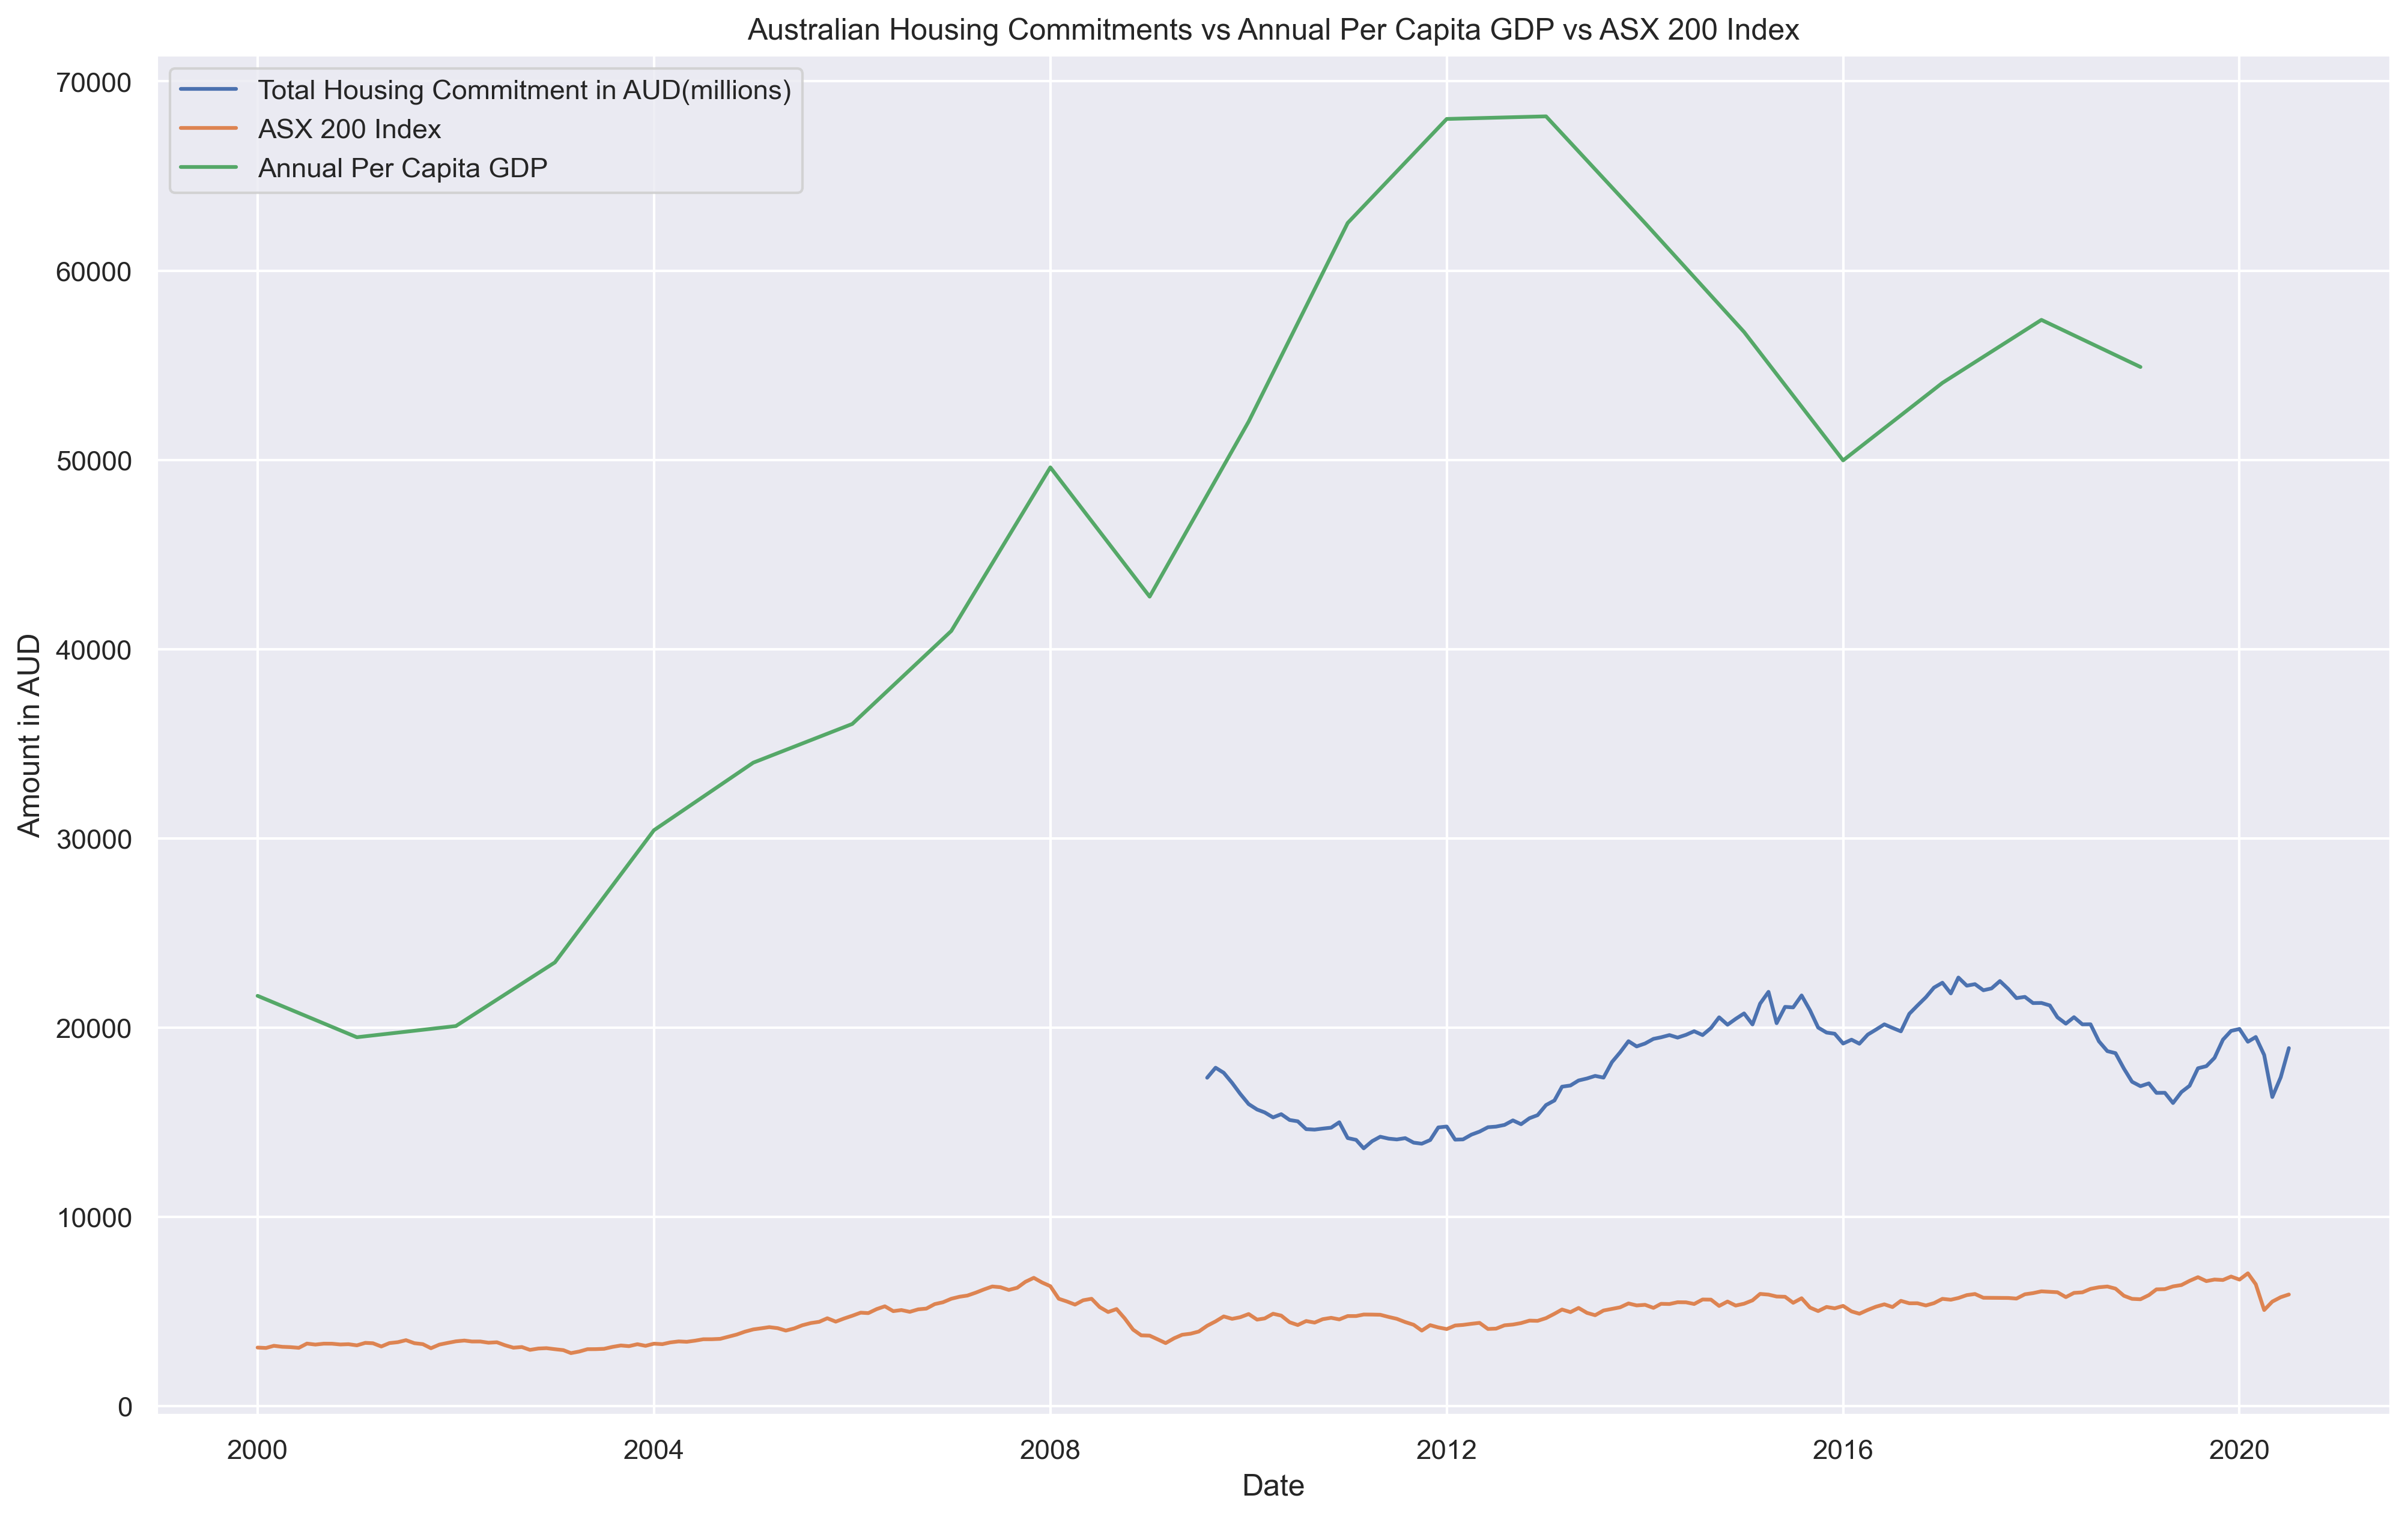

In [53]:
gdp_all = gdp_per_cap_all['GDP_per_cap'].tolist()
year = gdp_per_cap_all['Year'].tolist()
new_asx = asx200_month_all['open'].tolist()
new_month = asx200_month_all['date'].tolist()
new_total = house_commitment_all['Total'].tolist()
new_date = house_commitment_all['Date'].tolist()
fig = plt.figure(figsize = (16,10), dpi = 300)
plt.plot(new_date, new_total, label = "Total Housing Commitment in AUD(millions)")
plt.plot(new_month, new_asx, label = "ASX 200 Index")
plt.plot(year, gdp_all, label = "Annual Per Capita GDP")

plt.legend(loc="upper left")
plt.title('Australian Housing Commitments vs Annual Per Capita GDP vs ASX 200 Index')
plt.xlabel('Date')
plt.ylabel('Amount in AUD')
plt.show()